# Exploratory Data Analysis (EDA) | Minimarket Aurelion

## Información del Proyecto

| **Campo** | **Detalle** |
|-----------|-------------|
| Proyecto | Minimarket Aurelion - Pipeline de Datos Comerciales |
| Sprint | Sprint 2 - Análisis Exploratorio de Datos |
| Notebook | `8. EDA_Aurelion.ipynb` |
| Autor | Diego Armando Vásquez Chávez |
| Email | dvasquezc@certus.edu.pe |
| Fecha | 3 de noviembre de 2025 |
| Mentor | Mirta Gladys Julio |

---

## Objetivos Principales del EDA

- Validar integridad y consistencia de los datasets limpios.
- Detectar patrones de estacionalidad, outliers y correlaciones clave.
- Identificar concentraciones de ingresos para estrategias ABC.
- Generar insumos ejecutivos (tablas, figuras y logs) para la toma de decisiones.

---

## Entradas y Salidas del Notebook

### **Datasets de entrada (CSV)**
- `clientes_clean.csv` - Base depurada de clientes.
- `productos_clean.csv` - Catálogo limpio de productos.
- `ventas_clean.csv` - Ventas consolidadas sin inconsistencias.
- `detalle_clean.csv` - Detalle normalizado de líneas de venta.

### **Exportaciones clave (CSV)**
- `resumen_hallazgos.csv` - Síntesis de KPIs del EDA.
- `abc_clientes_validacion.csv` - Distribución ABC de clientes.
- `abc_productos_validacion.csv` - Distribución ABC de productos.
- `distribucion_canales_venta.csv` - Comparativa de canales locales vs web.
- `distribucion_medio_pago.csv` - Mix de medios de pago.
- `ticket_promedio_mensual.csv` - Evolución temporal de tickets.
- `ventas_mensuales_detalladas.csv` - Series temporales de ventas.

### ** Visualizaciones PNG (9 gráficos ejecutivos)**
- **Distribuciones**: Variables clave y detección de outliers.
- **Pareto**: Curvas ABC para productos y clientes.
- **Temporal**: Evolución de ventas con análisis de tendencias.
- **Correlación**: Heatmap de relaciones entre variables.
- **Elasticidad**: Scatter plots precio-demanda por categoría.
- **Comparativo**: Análisis de desempeño por categorías.
- **Medios de pago**: Distribución de canales de venta.

### ** Logs y Trazabilidad**
- `eda_log.log` - Registro estructurado de ejecución y métricas.
- `resumen_exportaciones_eda.csv` - Inventario completo de archivos generados.

---

##  Impacto Esperado

Al completar este análisis exploratorio, obtendremos:

✅ **Identificación de 34 productos y 27 clientes estrella** (Clase A) que concentran ~80% de los ingresos.  
✅ **Patrones de estacionalidad** y tendencias temporales para planificación estratégica.  
✅ **Insights de elasticidad precio-demanda** para optimización de márgenes comerciales.  
✅ **Segmentación clara por categorías** para asignación eficiente de recursos.  
✅ **Correlaciones clave** entre variables del negocio para estrategias integradas.  
✅ **Base sólida de features** preparada para algoritmos de Machine Learning.  

Este análisis proporcionará la **inteligencia de negocio** necesaria para la toma de decisiones data-driven y establecerá los fundamentos para la implementación de modelos predictivos en el Sprint 3.

---

## 🗺️ Navegación del Notebook

| **Sección** | **Descripción** | **Salidas Clave** |
|-------------|-----------------|-------------------|
| [1️⃣ Setup](#setup) | Configuración del entorno | Logging, rutas, librerías |
| [2️⃣ Carga de Datos](#carga) | Importación y diagnóstico | Validación dimensional |
| [3️⃣ Validaciones](#validacion) | Integridad referencial | Verificación FK |
| [4️⃣ Distribuciones](#distribuciones) | Análisis estadístico | Detección outliers |



# 1️⃣ SETUP Y CONFIGURACIÓN DEL ENTORNO <a id="setup"></a>

Configura rutas, logging y librerías necesarias para el análisis EDA.

- Inicialización del entorno de análisis
   - Configuración de rutas y logging estructurado
   - Carga de librerías especializadas (pandas, seaborn, matplotlib)

In [1]:
# Configuración de entorno, rutas y logging
%load_ext autoreload
%autoreload 2

import os
import logging
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

warnings.filterwarnings('ignore')

# Rutas base (relativas al proyecto)
BASE_DIR = Path.cwd()
DATASETS_LIMPIOS = BASE_DIR / 'datasets_limpios'
EXPORT_DIR = BASE_DIR / 'export'
FIG_DIR = BASE_DIR / 'visualizaciones_EDA'
for d in [EXPORT_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Estilo visual y formato numérico
sns.set_theme(style='whitegrid', palette='deep')
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams.update({'figure.dpi': 120, 'axes.titlesize': 13, 'axes.labelsize': 11})

# Helper para guardar figuras
SAVE_FIGS = True
def save_fig(name: str, dpi: int = 150):
    (FIG_DIR / f"{name}.png").parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(FIG_DIR / f"{name}.png", dpi=dpi, bbox_inches='tight')

# Logging básico
EDA_LOGGER = logging.getLogger('EDA_Aurelion')
if not EDA_LOGGER.handlers:
    EDA_LOGGER.setLevel(logging.INFO)
    sh = logging.StreamHandler()
    fh = logging.FileHandler(EXPORT_DIR / 'eda_log.log', encoding='utf-8')
    fmt = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s')
    sh.setFormatter(fmt); fh.setFormatter(fmt)
    EDA_LOGGER.addHandler(sh); EDA_LOGGER.addHandler(fh)
EDA_LOGGER.info('Entorno EDA inicializado')

2025-12-11 11:50:39,501 | INFO | Entorno EDA inicializado


---
# 2️⃣ CARGA DE DATOS Y DIAGNÓSTICO <a id="carga"></a>

Carga los datasets limpios (clientes, ventas, detalle, productos) y realiza un diagnóstico inicial de las tablas principales.

In [2]:
# Carga de datos desde datasets_limpios/
clientes = pd.read_csv(DATASETS_LIMPIOS / 'clientes_clean.csv')
ventas = pd.read_csv(DATASETS_LIMPIOS / 'ventas_clean.csv', parse_dates=['fecha'])
detalle = pd.read_csv(DATASETS_LIMPIOS / 'detalle_clean.csv')
productos = pd.read_csv(DATASETS_LIMPIOS / 'productos_clean.csv')

# Calcular importe_total si no existe en ventas
if 'importe_total' not in ventas.columns:
    importe_por_venta = detalle.groupby('id_venta')['importe'].sum().reset_index()
    importe_por_venta.columns = ['id_venta', 'importe_total']
    ventas = ventas.merge(importe_por_venta, on='id_venta', how='left')
    ventas['importe_total'] = ventas['importe_total'].fillna(0)

# Asegurar que importe_total sea una Serie válida
importe_total = ventas['importe_total'].copy()

print("="*80)
print("DIAGNÓSTICO INICIAL DE LOS DATOS")
print("="*80)
print(f"\n📊 Clientes:  {clientes.shape[0]:,} filas x {clientes.shape[1]} cols")
print(f"📊 Ventas:    {ventas.shape[0]:,} filas x {ventas.shape[1]} cols")
print(f"📊 Detalle:   {detalle.shape[0]:,} filas x {detalle.shape[1]} cols")
print(f"📊 Productos: {productos.shape[0]:,} filas x {productos.shape[1]} cols")
print("\n✅ Datasets cargados exitosamente")
EDA_LOGGER.info(f"Datos cargados: {ventas.shape[0]} ventas, {detalle.shape[0]} detalles")

2025-12-11 11:50:39,695 | INFO | Datos cargados: 12687 ventas, 11533 detalles


DIAGNÓSTICO INICIAL DE LOS DATOS

📊 Clientes:  1,187 filas x 5 cols
📊 Ventas:    12,687 filas x 10 cols
📊 Detalle:   11,533 filas x 6 cols
📊 Productos: 138 filas x 5 cols

✅ Datasets cargados exitosamente


---
# 3️⃣ VALIDACIONES DE INTEGRIDAD <a id="validacion"></a>

Valida la calidad e integridad de los datos: tipos, nulos, duplicados y claves foráneas.

   - Verificación de calidad de datos post-limpieza
   - Análisis de integridad referencial entre tablas
   - Detección de valores nulos y inconsistencias

In [3]:
# Validación de integridad referencial y nulos
print("="*80)
print("VALIDACIÓN DE INTEGRIDAD REFERENCIAL")
print("="*80)

# Análisis de valores nulos
nulos = ventas.isnull().sum()
if nulos.sum() == 0:
    print("\n✅ No se detectaron valores nulos en el dataset de ventas")
else:
    print(f"\n⚠️ Valores nulos detectados:\n{nulos[nulos > 0]}")

# Validación de claves foráneas
fk_clientes_ok = ventas['id_cliente'].isin(clientes['id_cliente']).all()
fk_productos_ok = detalle['id_producto'].isin(productos['id_producto']).all()
fk_ventas_ok = detalle['id_venta'].isin(ventas['id_venta']).all()

print(f"\n✓ ventas → clientes:  {'✅ VÁLIDO' if fk_clientes_ok else '❌ INVÁLIDO'}")
print(f"✓ detalle → productos: {'✅ VÁLIDO' if fk_productos_ok else '❌ INVÁLIDO'}")
print(f"✓ detalle → ventas:    {'✅ VÁLIDO' if fk_ventas_ok else '❌ INVÁLIDO'}")

# 🔍 DIAGNÓSTICO DETALLADO si hay problemas
if not fk_ventas_ok:
    print("\n🔍 DIAGNÓSTICO: Registros huérfanos en detalle → ventas")
    huerfanos_detalle = detalle[~detalle['id_venta'].isin(ventas['id_venta'])]
    ids_huerfanos = huerfanos_detalle['id_venta'].unique()
    print(f"   📊 Total registros huérfanos en detalle: {len(huerfanos_detalle):,}")
    print(f"   🔢 IDs de venta huérfanos: {sorted(ids_huerfanos)[:10]}..." if len(ids_huerfanos) > 10 else f"   🔢 IDs de venta huérfanos: {sorted(ids_huerfanos)}")
    print(f"   📈 % de detalle afectado: {len(huerfanos_detalle)/len(detalle)*100:.2f}%")
    
    # Mostrar ejemplo de registros huérfanos
    print(f"\n   📋 Ejemplo de registros huérfanos:")
    print(huerfanos_detalle[['id_venta', 'id_producto', 'cantidad', 'importe']].head(3).to_string(index=False))

if not fk_productos_ok:
    print("\n🔍 DIAGNÓSTICO: Registros huérfanos en detalle → productos")
    huerfanos_productos = detalle[~detalle['id_producto'].isin(productos['id_producto'])]
    print(f"   📊 Total registros huérfanos: {len(huerfanos_productos):,}")
    print(f"   📈 % de detalle afectado: {len(huerfanos_productos)/len(detalle)*100:.2f}%")

if not fk_clientes_ok:
    print("\n🔍 DIAGNÓSTICO: Registros huérfanos en ventas → clientes")
    huerfanos_clientes = ventas[~ventas['id_cliente'].isin(clientes['id_cliente'])]
    print(f"   📊 Total registros huérfanos: {len(huerfanos_clientes):,}")
    print(f"   📈 % de ventas afectado: {len(huerfanos_clientes)/len(ventas)*100:.2f}%")

print("="*80)

if fk_clientes_ok and fk_productos_ok and fk_ventas_ok:
    print("\n✅ Todas las validaciones de integridad pasaron correctamente")
    EDA_LOGGER.info("Validaciones de integridad: OK")
else:
    print("\n⚠️ ACCIÓN REQUERIDA: Corregir integridad referencial antes de continuar")
    print("   💡 Opciones: eliminar huérfanos o corregir IDs en el proceso de limpieza")
    EDA_LOGGER.warning("Validaciones de integridad: FALLOS detectados")

2025-12-11 11:50:39,758 | WARNING | Validaciones de integridad: FALLOS detectados


VALIDACIÓN DE INTEGRIDAD REFERENCIAL

⚠️ Valores nulos detectados:
canal              29
csat_1a5         2322
ces_1a5          3080
nps_0a10        10508
nps_segmento    10508
dtype: int64

✓ ventas → clientes:  ✅ VÁLIDO
✓ detalle → productos: ❌ INVÁLIDO
✓ detalle → ventas:    ❌ INVÁLIDO

🔍 DIAGNÓSTICO: Registros huérfanos en detalle → ventas
   📊 Total registros huérfanos en detalle: 34
   🔢 IDs de venta huérfanos: [np.int64(494), np.int64(851), np.int64(1632), np.int64(1726), np.int64(2734), np.int64(3779), np.int64(4089), np.int64(4367), np.int64(4448), np.int64(5142)]...
   📈 % de detalle afectado: 0.29%

   📋 Ejemplo de registros huérfanos:
 id_venta  id_producto  cantidad  importe
      494           52      3.00 4,236.00
      851           23      4.00 8,752.00
     1632          123      2.00 1,692.00

🔍 DIAGNÓSTICO: Registros huérfanos en detalle → productos
   📊 Total registros huérfanos: 136
   📈 % de detalle afectado: 1.18%

⚠️ ACCIÓN REQUERIDA: Corregir integridad refere

---
# 4️⃣ ANÁLISIS DE DISTRIBUCIONES <a id="distribuciones"></a>

Analiza la distribución de variables numéricas y detecta outliers en los datos de ventas.

- Distribuciones de variables numéricas clave
- Detección de outliers mediante método IQR
- Análisis de correlaciones entre variables de negocio

DISTRIBUCIÓN DE IMPORTES TOTALES POR VENTA
count   12,687.00
mean     4,827.56
std      3,144.19
min          0.00
25%      2,292.00
50%      4,255.00
75%      6,766.50
max     15,215.00
Name: importe_total, dtype: float64


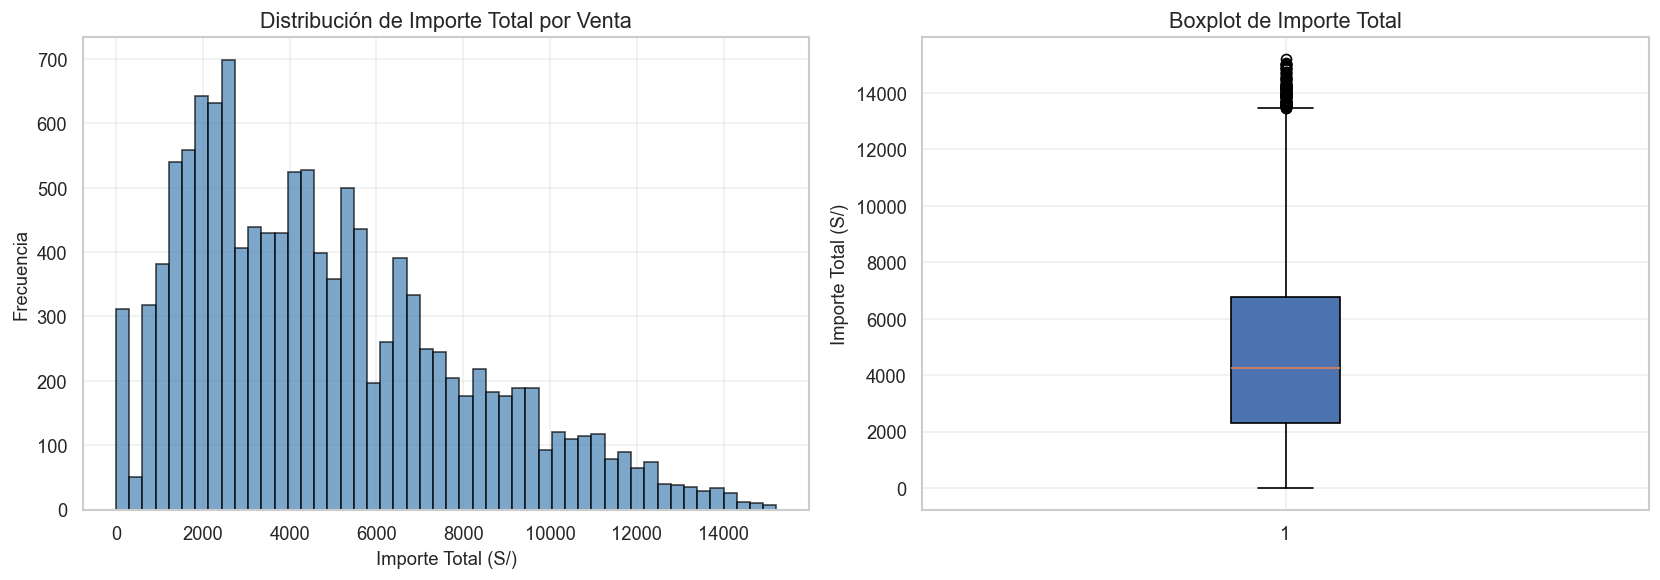

2025-12-11 11:50:40,437 | INFO | Distribución analizada: media=4827.56, mediana=4255.00


In [4]:
# Análisis de distribución de importe_total
print("="*80)
print("DISTRIBUCIÓN DE IMPORTES TOTALES POR VENTA")
print("="*80)
print(importe_total.describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Histograma + KDE
axes[0].hist(importe_total, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Distribución de Importe Total por Venta')
axes[0].set_xlabel('Importe Total (S/)')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(alpha=0.3)

# Boxplot
axes[1].boxplot(importe_total, vert=True, patch_artist=True)
axes[1].set_title('Boxplot de Importe Total')
axes[1].set_ylabel('Importe Total (S/)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
if SAVE_FIGS:
    save_fig('03_distribucion_importes')
plt.show()
EDA_LOGGER.info(f"Distribución analizada: media={importe_total.mean():.2f}, mediana={importe_total.median():.2f}")

### 🧠 Interpretación: Distribución de importes
- La media/mediana muestran tendencia central; revisar asimetrías por outliers.
- Alta variabilidad sugiere segmentar por categoría/canal.
- Implicación: ajustar políticas de outliers y promociones.

---
# 5️⃣ MEDIOS DE PAGO Y CANALES <a id="medios"></a>

Analiza la distribución y participación de medios de pago y canales de venta.

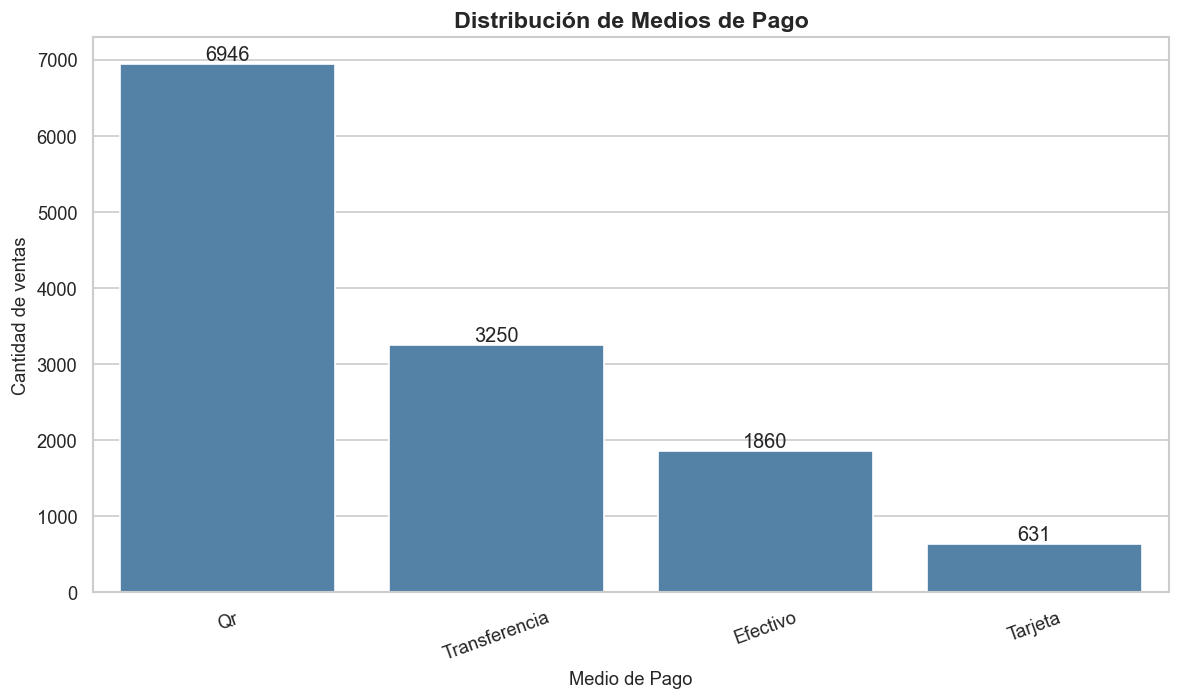

2025-12-11 11:50:40,836 | INFO | Medio de pago dominante: Qr (54.75%)



✅ Distribución de medios de pago analizada y exportada


In [5]:
# Análisis de medios de pago
if 'medio_pago' in ventas.columns:
    mp_counts = ventas['medio_pago'].astype(str).str.strip().value_counts().sort_values(ascending=False)
    mp_pct = (mp_counts / mp_counts.sum() * 100).round(2)
    df_medio_pago = pd.DataFrame({'medio_pago': mp_counts.index, 'cantidad': mp_counts.values, 'porcentaje': mp_pct.values})
    df_medio_pago.to_csv(EXPORT_DIR / 'distribucion_medio_pago.csv', index=False)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x='medio_pago', y='cantidad', data=df_medio_pago, ax=ax, color='steelblue')
    ax.set_title('Distribución de Medios de Pago', fontsize=14, fontweight='bold')
    ax.set_xlabel('Medio de Pago')
    ax.set_ylabel('Cantidad de ventas')
    ax.bar_label(ax.containers[0])
    plt.xticks(rotation=20)
    plt.tight_layout()
    if SAVE_FIGS:
        save_fig('01_medio_pago')
    plt.show()
    print("\n✅ Distribución de medios de pago analizada y exportada")
    EDA_LOGGER.info(f"Medio de pago dominante: {mp_counts.idxmax()} ({mp_pct.max()}%)")
else:
    print('⚠️ Columna medio_pago no disponible en ventas.')
    EDA_LOGGER.warning("medio_pago no encontrado en ventas")


ANÁLISIS DE CANALES DE VENTA
✓ Columna 'canal' encontrada - Análisis directo


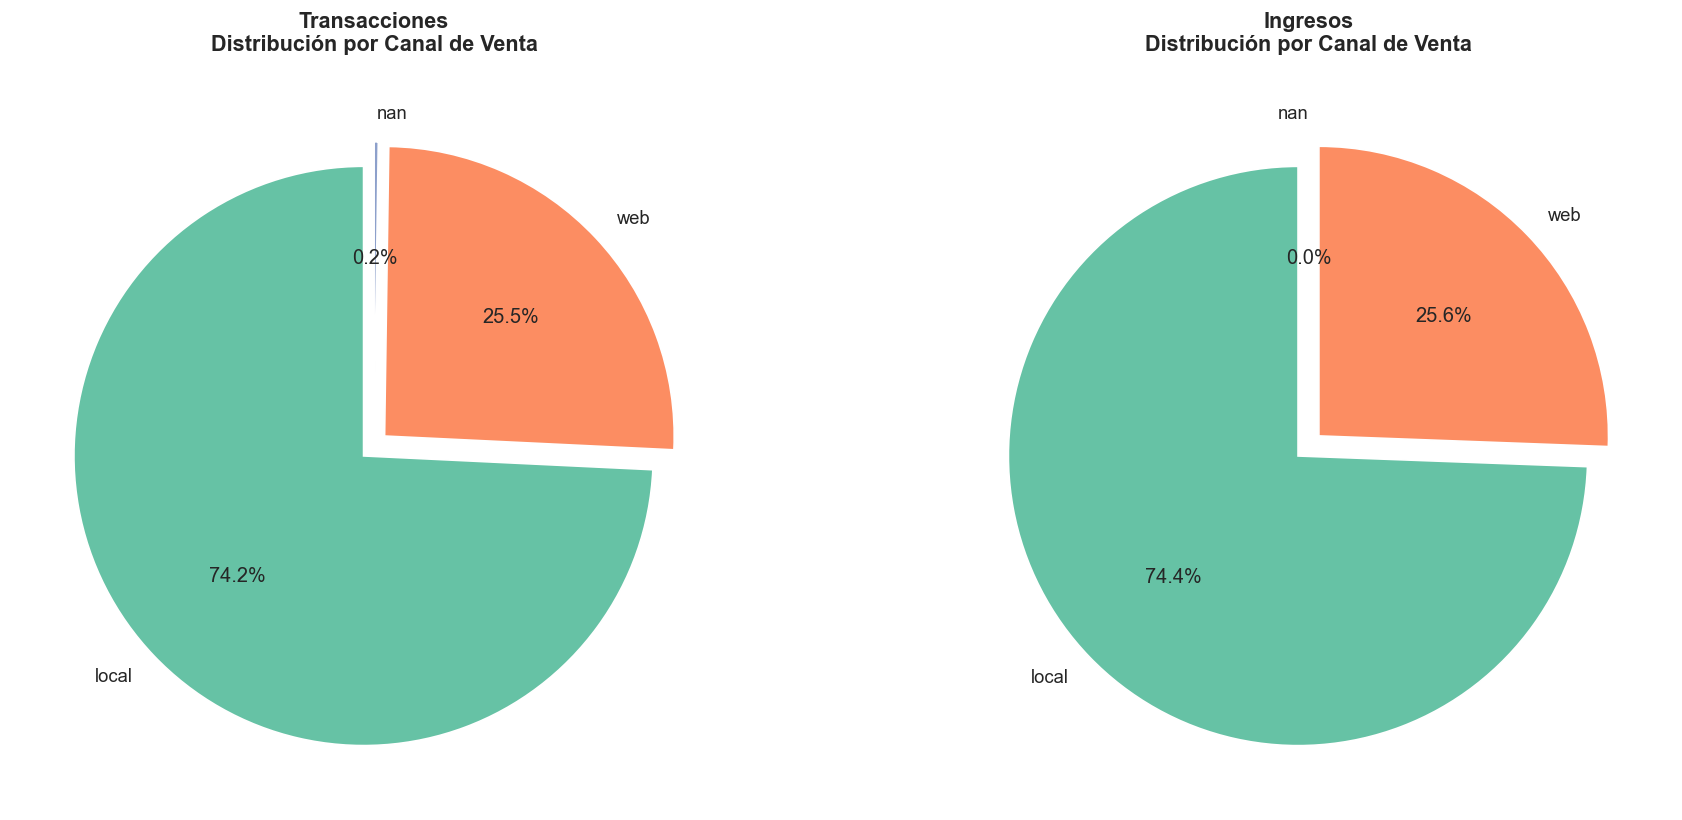

2025-12-11 11:50:41,206 | INFO | Análisis de canales completado: 3 canales identificados



📊 RESUMEN DE CANALES:
   • Total canales identificados: 3
   • Canal dominante (transacciones): local (74.2%)
   • Canal dominante (ingresos): local (74.4%)
   ⚠️ ALERTA: Alta concentración en transacciones (74.2%)
   ⚠️ ALERTA: Alta concentración en ingresos (74.4%)

✅ Archivo exportado: distribucion_canales_venta.csv


In [6]:
# ===== ANÁLISIS DE CANALES DE VENTA =====

print("\n" + "="*80)
print("ANÁLISIS DE CANALES DE VENTA")
print("="*80)

# Verificar si existe columna 'canal' en ventas
if 'canal' in ventas.columns:
    print("✓ Columna 'canal' encontrada - Análisis directo")
    
    # Análisis directo por canal
    canal_dist = ventas['canal'].astype(str).str.strip().value_counts().sort_values(ascending=False)
    canal_pct_dist = (canal_dist / canal_dist.sum() * 100).round(2)
    
    # Ingresos por canal
    ingresos_por_canal = ventas.groupby('canal')['importe_total'].sum().sort_values(ascending=False)
    ingresos_pct_dist = (ingresos_por_canal / ingresos_por_canal.sum() * 100).round(2)
    
    # DataFrame consolidado
    df_canales_consolidado = pd.DataFrame({
        'canal': canal_dist.index,
        'transacciones': canal_dist.values,
        'pct_transacciones': canal_pct_dist.values,
        'ingresos': [ingresos_por_canal.get(canal, 0) for canal in canal_dist.index],
        'pct_ingresos': [ingresos_pct_dist.get(canal, 0) for canal in canal_dist.index]
    })
    
    archivo_export = 'distribucion_canales_venta.csv'
    titulo_grafico = 'Distribución por Canal de Venta'
    nombre_imagen = '02_distribucion_canales_directos'
    
else:
    print("⚠️ Columna 'canal' no encontrada - Infiriendo desde medio_pago")
    
    if 'medio_pago' not in ventas.columns:
        print("❌ Tampoco se encontró 'medio_pago' - No se puede analizar canales")
        EDA_LOGGER.warning("Sin datos de canal ni medio_pago disponibles")
    else:
        # Mapeo de medios de pago a canales
        mapeo_canales = {
            'Efectivo': 'Presencial',
            'Tarjeta': 'Presencial/Digital', 
            'Transferencia': 'Digital',
            'Yape': 'Digital',
            'Plin': 'Digital',
            'Credito': 'Presencial'
        }
        
        # Crear canal inferido
        ventas['canal_temp'] = ventas['medio_pago'].astype(str).str.title().map(mapeo_canales).fillna('Otro')
        
        # Análisis por canal inferido
        canal_dist = ventas['canal_temp'].value_counts().sort_values(ascending=False)
        canal_pct_dist = (canal_dist / canal_dist.sum() * 100).round(2)
        
        # Ingresos por canal inferido
        ingresos_por_canal = ventas.groupby('canal_temp')['importe_total'].sum().sort_values(ascending=False)
        ingresos_pct_dist = (ingresos_por_canal / ingresos_por_canal.sum() * 100).round(2)
        
        # DataFrame consolidado
        df_canales_consolidado = pd.DataFrame({
            'canal': canal_dist.index,
            'transacciones': canal_dist.values,
            'pct_transacciones': canal_pct_dist.values,
            'ingresos': [ingresos_por_canal.get(canal, 0) for canal in canal_dist.index],
            'pct_ingresos': [ingresos_pct_dist.get(canal, 0) for canal in canal_dist.index]
        })
        
        archivo_export = 'distribucion_canales_inferidos.csv'
        titulo_grafico = 'Distribución por Canal Inferido\n(desde Medio de Pago)'
        nombre_imagen = '02_distribucion_canales_inferidos'

# Solo continuar si tenemos datos de canales
if 'df_canales_consolidado' in locals():
    
    # Exportar datos
    df_canales_consolidado.to_csv(EXPORT_DIR / archivo_export, index=False)
    
    # Crear visualización
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Paleta de colores
    colores = sns.color_palette('Set2', n_colors=len(df_canales_consolidado))
    
    # Gráfico 1: Transacciones
    axes[0].pie(df_canales_consolidado['transacciones'], 
                labels=df_canales_consolidado['canal'],
                autopct='%1.1f%%',
                colors=colores, 
                startangle=90,
                explode=[0.05] * len(df_canales_consolidado))
    axes[0].set_title(f'Transacciones\n{titulo_grafico}', fontsize=13, fontweight='bold', pad=20)
    
    # Gráfico 2: Ingresos
    axes[1].pie(df_canales_consolidado['ingresos'], 
                labels=df_canales_consolidado['canal'],
                autopct='%1.1f%%',
                colors=colores, 
                startangle=90,
                explode=[0.05] * len(df_canales_consolidado))
    axes[1].set_title(f'Ingresos\n{titulo_grafico}', fontsize=13, fontweight='bold', pad=20)
    
    plt.tight_layout()
    if SAVE_FIGS:
        save_fig(nombre_imagen)
    plt.show()
    
    # Resumen ejecutivo
    print(f"\n📊 RESUMEN DE CANALES:")
    print(f"   • Total canales identificados: {len(df_canales_consolidado)}")
    print(f"   • Canal dominante (transacciones): {df_canales_consolidado.iloc[0]['canal']} ({df_canales_consolidado.iloc[0]['pct_transacciones']:.1f}%)")
    print(f"   • Canal dominante (ingresos): {df_canales_consolidado.sort_values('pct_ingresos', ascending=False).iloc[0]['canal']} ({df_canales_consolidado.sort_values('pct_ingresos', ascending=False).iloc[0]['pct_ingresos']:.1f}%)")
    
    # Análisis de concentración
    max_trans_pct = df_canales_consolidado['pct_transacciones'].max()
    max_ingresos_pct = df_canales_consolidado['pct_ingresos'].max()
    
    if max_trans_pct > 70:
        print(f"   ⚠️ ALERTA: Alta concentración en transacciones ({max_trans_pct:.1f}%)")
    if max_ingresos_pct > 70:
        print(f"   ⚠️ ALERTA: Alta concentración en ingresos ({max_ingresos_pct:.1f}%)")
    
    print(f"\n✅ Archivo exportado: {archivo_export}")
    EDA_LOGGER.info(f"Análisis de canales completado: {len(df_canales_consolidado)} canales identificados")

print("="*80)

### 🧠 Interpretación: Medios de pago
- Definir campañas según el medio dominante.
- Diversificar reduce riesgo si la concentración es alta.
- Explorar comisiones vs ticket promedio por medio.

---
# 6️⃣ TICKET PROMEDIO MENSUAL <a id="ticket"></a>

Calcula y grafica el ticket promedio mensual de ventas. Útil para analizar tendencias y estacionalidad.

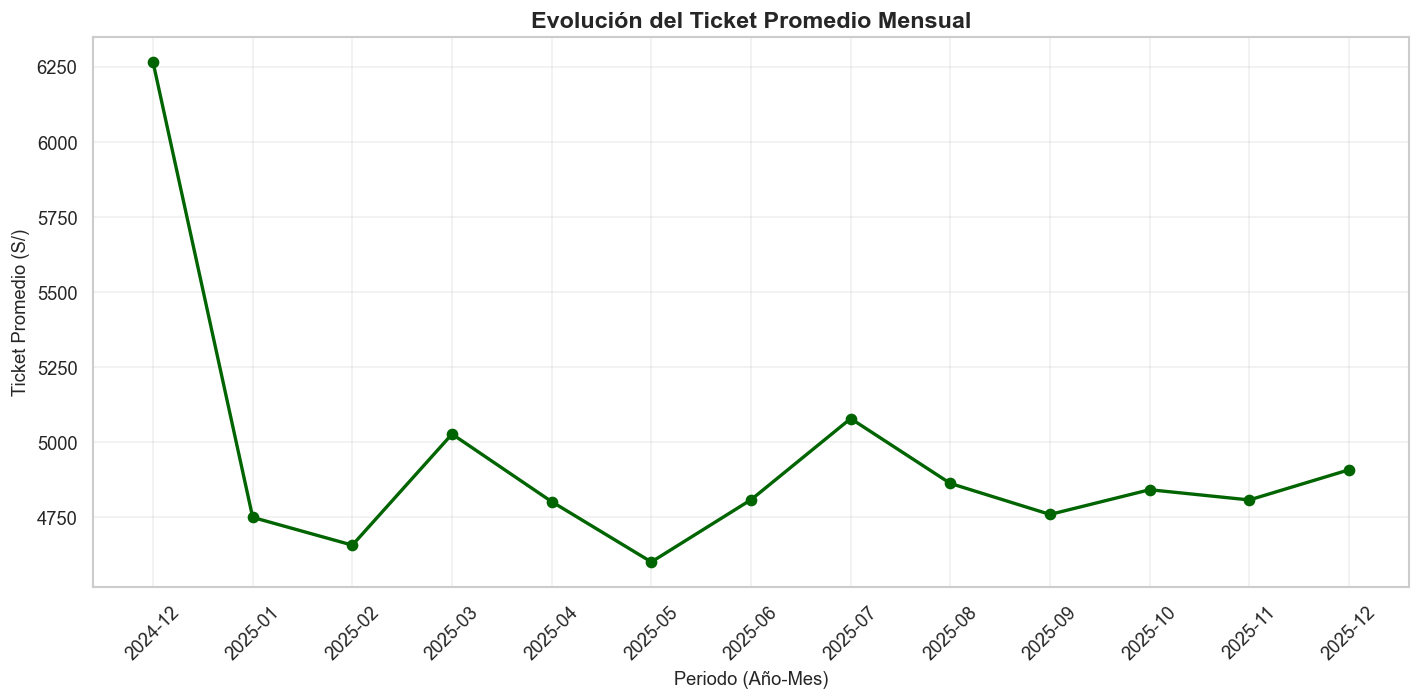

2025-12-11 11:50:41,699 | INFO | Ticket promedio general: S/ 4935.87



✅ Ticket promedio mensual calculado y exportado


In [7]:
# Calcular ticket promedio mensual
ventas['anio_mes'] = ventas['fecha'].dt.to_period('M').astype(str)
ticket_promedio = ventas.groupby('anio_mes')['importe_total'].mean().round(2)
ticket_promedio_df = ticket_promedio.reset_index().rename(columns={'importe_total': 'ticket_promedio'})
ticket_promedio_df.to_csv(EXPORT_DIR / 'ticket_promedio_mensual.csv', index=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ticket_promedio.index, ticket_promedio.values, marker='o', linewidth=2, color='darkgreen')
ax.set_title('Evolución del Ticket Promedio Mensual', fontsize=14, fontweight='bold')
ax.set_xlabel('Periodo (Año-Mes)')
ax.set_ylabel('Ticket Promedio (S/)')
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
if SAVE_FIGS:
    save_fig('06_ticket_promedio_mensual')
plt.show()
print("\n✅ Ticket promedio mensual calculado y exportado")
EDA_LOGGER.info(f"Ticket promedio general: S/ {ticket_promedio.mean():.2f}")

---
# 7️⃣ TOP PRODUCTOS Y CLASIFICACIÓN ABC <a id="abc"></a>

Calcula y visualiza la clasificación ABC para productos y clientes, mostrando los top 5 y su impacto en ventas.

2025-12-11 11:50:41,764 | INFO | ABC Productos: Clase A=44, B=49, C=46


CLASIFICACIÓN ABC DE PRODUCTOS
               Ingresos Totales  Cantidad  % del Total
Clasificacion                                         
A                 45,303,673.00        44        79.69
B                  8,639,698.00        49        15.21
C                  2,912,757.00        46         5.12

✅ Clasificación ABC exportada a: c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\export\clasificacion_abc_productos.csv


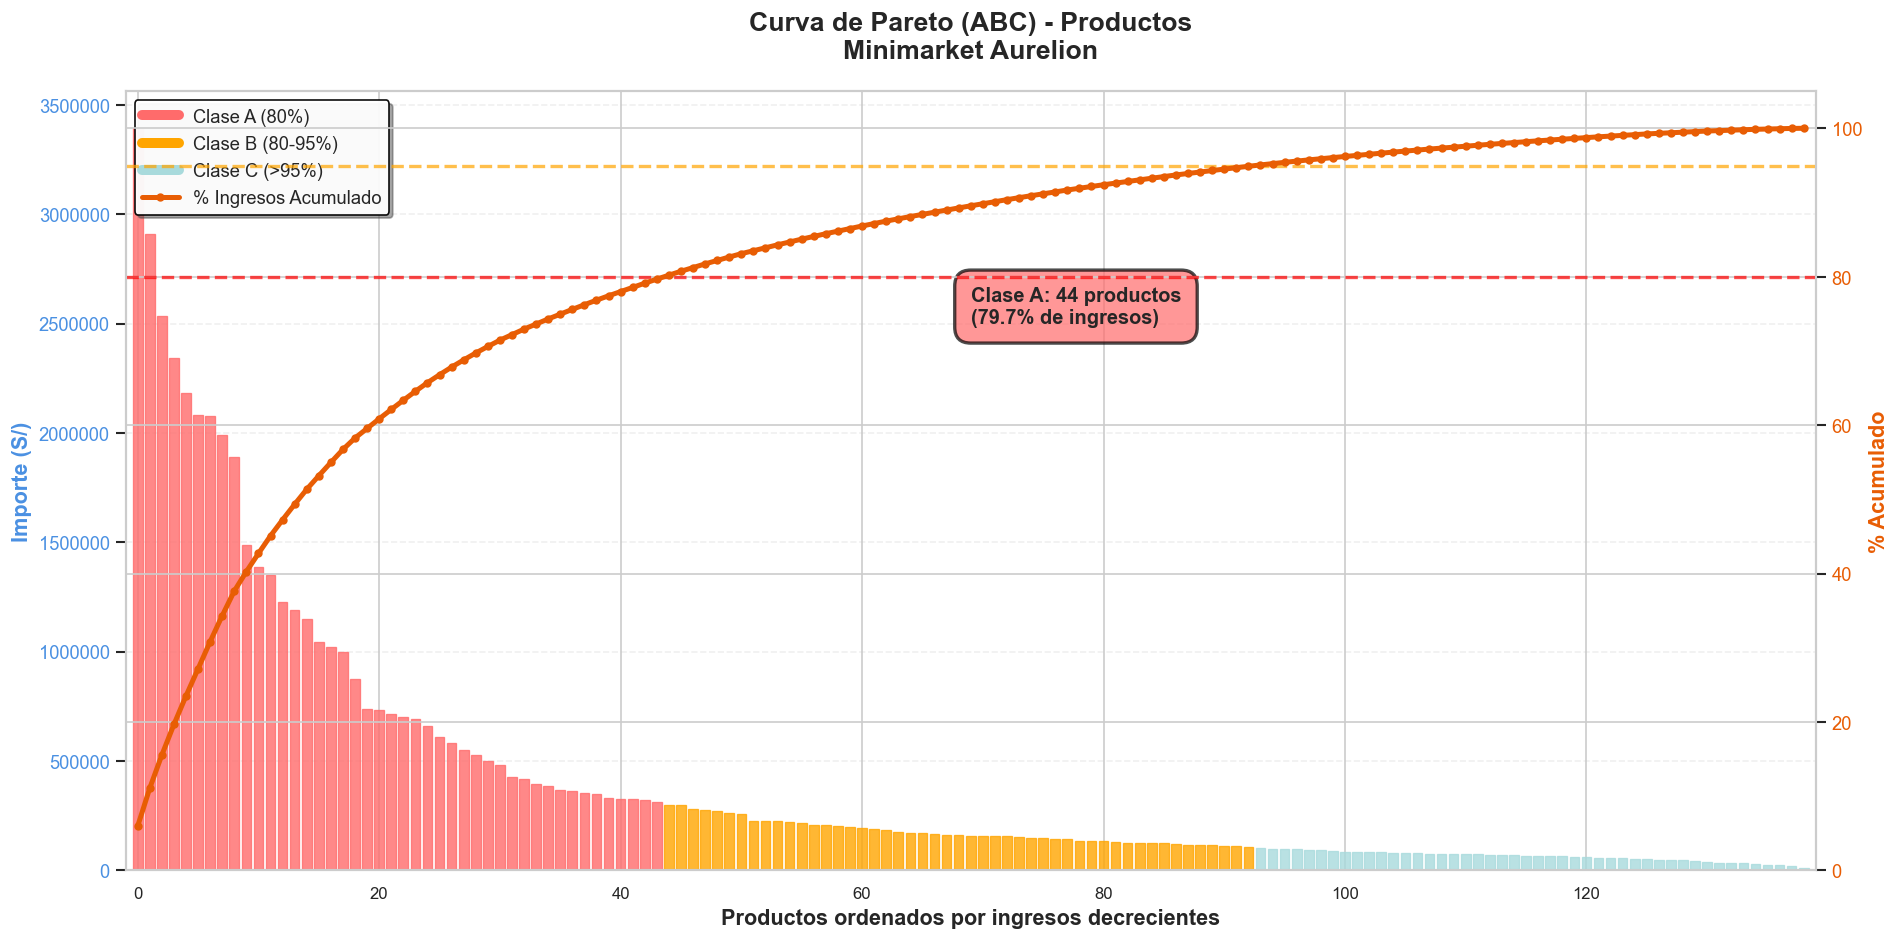


✅ Curva de Pareto de productos generada


In [8]:
# Clasificación ABC de productos
ingresos_producto = detalle.groupby('id_producto')['importe'].sum().sort_values(ascending=False)
total_ingresos = ingresos_producto.sum()
porcentaje_prod = (ingresos_producto / total_ingresos * 100).round(2)
porcentaje_acum_prod = porcentaje_prod.cumsum().round(2)

def clasificar_abc(pct_acum):
    if pct_acum <= 80:
        return 'A'
    elif pct_acum <= 95:
        return 'B'
    else:
        return 'C'

clasificacion_prod = porcentaje_acum_prod.apply(clasificar_abc)
df_abc_productos = pd.DataFrame({
    'Ingresos': ingresos_producto,
    '% Individual': porcentaje_prod,
    '% Acumulado': porcentaje_acum_prod,
    'Clasificacion': clasificacion_prod
})

# Exportar
abc_productos_path = EXPORT_DIR / 'clasificacion_abc_productos.csv'
df_abc_productos.to_csv(abc_productos_path)

print("="*80)
print("CLASIFICACIÓN ABC DE PRODUCTOS")
print("="*80)
resumen = df_abc_productos.groupby('Clasificacion').agg({'Ingresos': ['sum', 'count'], '% Individual': 'sum'}).round(2)
resumen.columns = ['Ingresos Totales', 'Cantidad', '% del Total']
print(resumen)
print(f"\n✅ Clasificación ABC exportada a: {abc_productos_path}")
EDA_LOGGER.info(f"ABC Productos: Clase A={resumen.loc['A', 'Cantidad']}, B={resumen.loc['B', 'Cantidad'] if 'B' in resumen.index else 0}, C={resumen.loc['C', 'Cantidad'] if 'C' in resumen.index else 0}")

# ==================== VISUALIZACIÓN CURVA DE PARETO - PRODUCTOS ====================
fig, ax1 = plt.subplots(figsize=(16, 8))

# Preparar datos para visualización
n_productos = len(df_abc_productos)
x_productos = np.arange(n_productos)

# Eje principal: Barras de ingresos
color_bars = '#4A90E2'
bars = ax1.bar(x_productos, df_abc_productos['Ingresos'], 
               color=color_bars, alpha=0.7, edgecolor='black', linewidth=0.8)

# Colorear barras según clasificación ABC
colors_abc = {'A': '#FF6B6B', 'B': '#FFA500', 'C': '#A8DADC'}
for i, (idx, row) in enumerate(df_abc_productos.iterrows()):
    bars[i].set_color(colors_abc[row['Clasificacion']])
    bars[i].set_alpha(0.8)

ax1.set_xlabel('Productos ordenados por ingresos decrecientes', fontsize=13, fontweight='bold')
ax1.set_ylabel('Importe (S/)', fontsize=13, fontweight='bold', color=color_bars)
ax1.tick_params(axis='y', labelcolor=color_bars, labelsize=11)
ax1.tick_params(axis='x', labelsize=10)
ax1.ticklabel_format(style='plain', axis='y')
ax1.set_xlim(-1, n_productos)

# Eje secundario: Línea de porcentaje acumulado
ax2 = ax1.twinx()
color_line = '#E85D04'
line = ax2.plot(x_productos, df_abc_productos['% Acumulado'], 
                color=color_line, linewidth=3, marker='o', markersize=4, 
                label='% Ingresos Acumulado', zorder=5)

ax2.set_ylabel('% Acumulado', fontsize=13, fontweight='bold', color=color_line)
ax2.tick_params(axis='y', labelcolor=color_line, labelsize=11)
ax2.set_ylim(0, 105)

# Líneas horizontales de referencia (80% y 95%)
ax2.axhline(y=80, color='red', linestyle='--', linewidth=2, alpha=0.7, label='80% (Frontera Clase A)')
ax2.axhline(y=95, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='95% (Frontera Clase B)')

# Título y grid
ax1.set_title('Curva de Pareto (ABC) - Productos\nMinimarket Aurelion', 
              fontsize=16, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Leyenda combinada
lines_labels = [plt.Line2D([0], [0], color=colors_abc['A'], lw=6, label='Clase A (80%)'),
                plt.Line2D([0], [0], color=colors_abc['B'], lw=6, label='Clase B (80-95%)'),
                plt.Line2D([0], [0], color=colors_abc['C'], lw=6, label='Clase C (>95%)')]
ax1.legend(handles=lines_labels + line, loc='upper left', fontsize=11, framealpha=0.95, 
           edgecolor='black', shadow=True)

# Anotaciones para clase A
clase_a_count = (df_abc_productos['Clasificacion'] == 'A').sum()
clase_a_pct = resumen.loc['A', '% del Total']
ax1.text(0.5, 0.75, f'Clase A: {clase_a_count} productos\n({clase_a_pct:.1f}% de ingresos)', 
         transform=ax1.transAxes, fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.8', facecolor='#FF6B6B', alpha=0.7, edgecolor='black', linewidth=2),
         verticalalignment='top')

plt.tight_layout()
if SAVE_FIGS:
    save_fig('07_pareto_productos_abc', dpi=200)
plt.show()

print("\n✅ Curva de Pareto de productos generada")

---
## 📊 Clasificación ABC de Clientes

Aplica el análisis de Pareto para identificar clientes más valiosos según el principio 80/20.


CLASIFICACIÓN ABC DE CLIENTES
               Ingresos Totales  Cantidad  % del Total
Clasificacion                                         
A                 48,817,892.00        26        79.72
B                  9,359,853.00       183        15.28
C                  3,069,501.00       430         4.85

✅ Clasificación ABC de clientes exportada a: c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\export\clasificacion_abc_clientes.csv


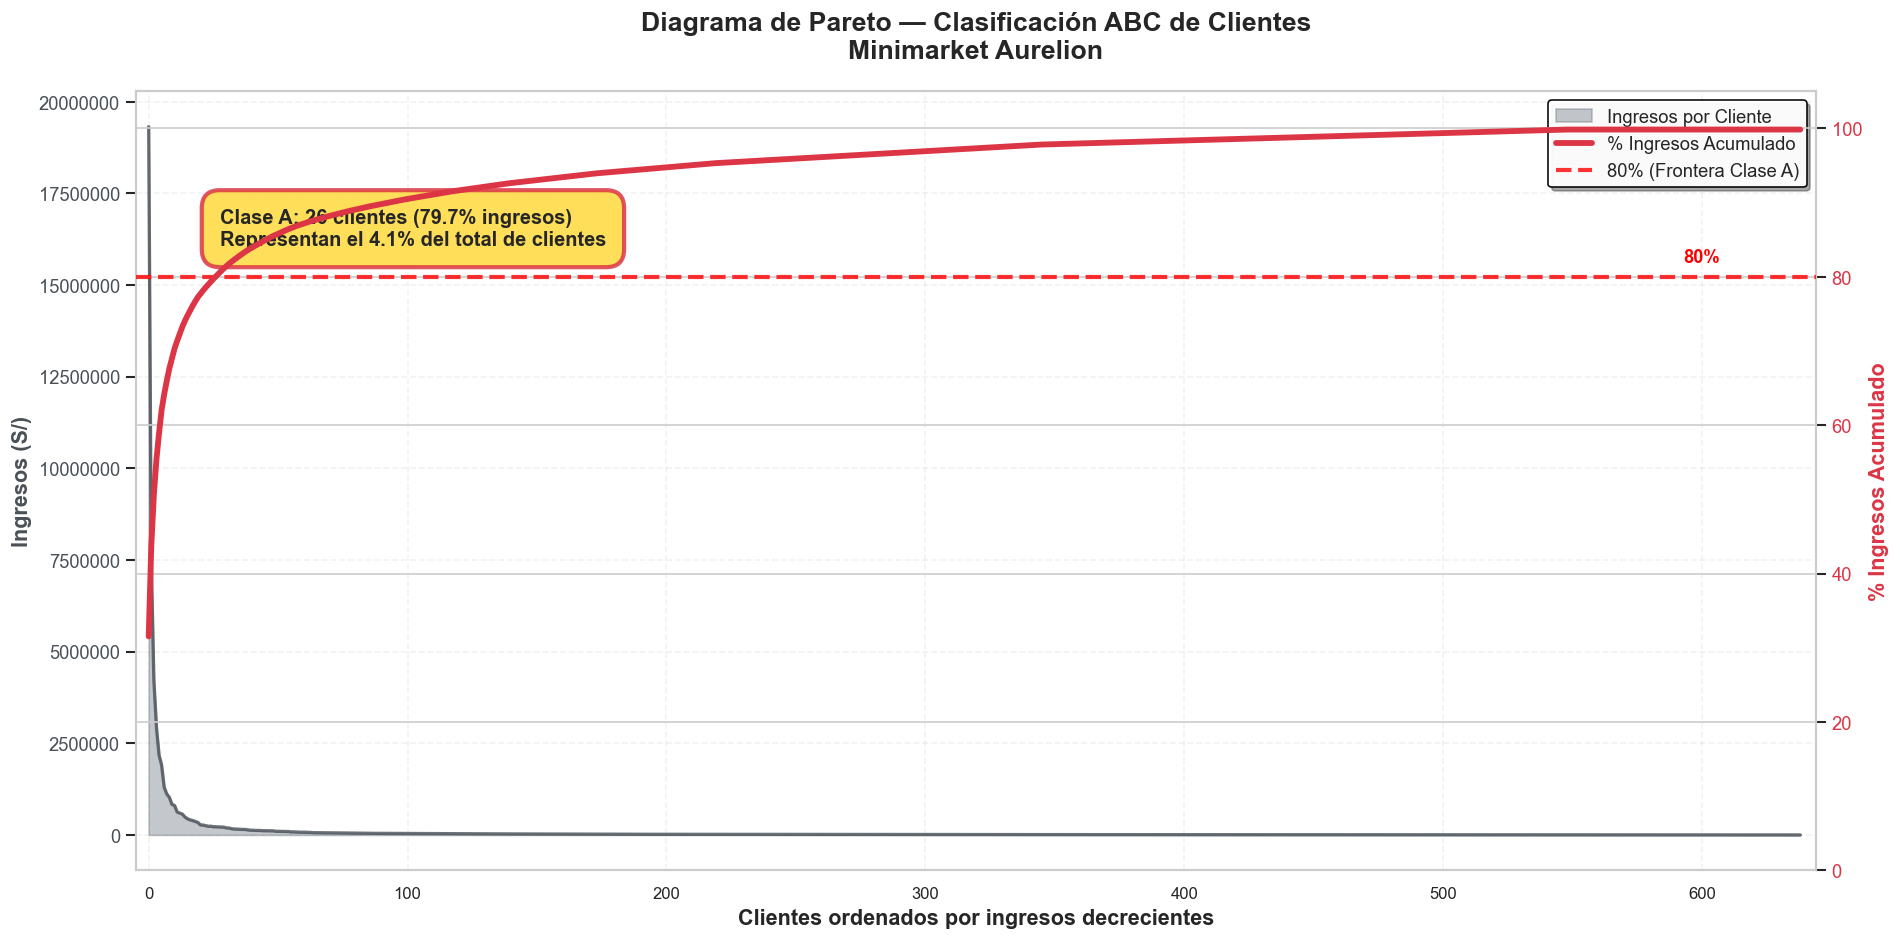

2025-12-11 11:50:44,024 | INFO | ABC Clientes: Clase A=26, B=183, C=430



✅ Curva de Pareto de clientes generada


In [9]:
# Clasificación ABC de clientes
print("\n" + "="*80)
print("CLASIFICACIÓN ABC DE CLIENTES")
print("="*80)

# Calcular ingresos por cliente
ingresos_cliente = ventas.groupby('id_cliente')['importe_total'].sum().sort_values(ascending=False)
total_ingresos_clientes = ingresos_cliente.sum()
porcentaje_cli = (ingresos_cliente / total_ingresos_clientes * 100).round(2)
porcentaje_acum_cli = porcentaje_cli.cumsum().round(2)

clasificacion_cli = porcentaje_acum_cli.apply(clasificar_abc)
df_abc_clientes = pd.DataFrame({
    'Ingresos': ingresos_cliente,
    '% Individual': porcentaje_cli,
    '% Acumulado': porcentaje_acum_cli,
    'Clasificacion': clasificacion_cli
})

# Exportar con manejo de archivo bloqueado (Windows)
abc_clientes_path = EXPORT_DIR / 'clasificacion_abc_clientes.csv'
try:
    df_abc_clientes.to_csv(abc_clientes_path, index=False)
    export_msg = f"✅ Clasificación ABC de clientes exportada a: {abc_clientes_path}"
except PermissionError:
    ts = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    abc_clientes_path = EXPORT_DIR / f'clasificacion_abc_clientes_{ts}.csv'
    df_abc_clientes.to_csv(abc_clientes_path, index=False)
    export_msg = f"⚠️ Archivo en uso; se guardó como: {abc_clientes_path.name}"

# Resumen por clase
resumen_cli = df_abc_clientes.groupby('Clasificacion').agg({
    'Ingresos': ['sum', 'count'], 
    '% Individual': 'sum'
}).round(2)
resumen_cli.columns = ['Ingresos Totales', 'Cantidad', '% del Total']
print(resumen_cli)
print(f"\n{export_msg}")

# ==================== VISUALIZACIÓN CURVA DE PARETO - CLIENTES ====================
fig, ax1 = plt.subplots(figsize=(16, 8))

# Preparar datos
n_clientes = len(df_abc_clientes)
x_clientes = np.arange(n_clientes)

# Gráfico de área para ingresos por cliente
ax1.fill_between(x_clientes, df_abc_clientes['Ingresos'], 
                 color='#6C757D', alpha=0.4, label='Ingresos por Cliente')
ax1.plot(x_clientes, df_abc_clientes['Ingresos'], 
         color='#495057', linewidth=2, alpha=0.8)

ax1.set_xlabel('Clientes ordenados por ingresos decrecientes', fontsize=13, fontweight='bold')
ax1.set_ylabel('Ingresos (S/)', fontsize=13, fontweight='bold', color='#495057')
ax1.tick_params(axis='y', labelcolor='#495057', labelsize=11)
ax1.tick_params(axis='x', labelsize=10)
ax1.ticklabel_format(style='plain', axis='y')
ax1.set_xlim(-5, n_clientes + 5)

# Eje secundario: Línea de % acumulado
ax2 = ax1.twinx()
color_line_cli = '#DC3545'
line_cli = ax2.plot(x_clientes, df_abc_clientes['% Acumulado'], 
                    color=color_line_cli, linewidth=3.5, marker='', 
                    label='% Ingresos Acumulado', zorder=5)

ax2.set_ylabel('% Ingresos Acumulado', fontsize=13, fontweight='bold', color=color_line_cli)
ax2.tick_params(axis='y', labelcolor=color_line_cli, labelsize=11)
ax2.set_ylim(0, 105)

# Líneas de referencia 80% y 95%
ax2.axhline(y=80, color='red', linestyle='--', linewidth=2.5, alpha=0.8, 
            label='80% (Frontera Clase A)', zorder=4)
ax2.text(max(1, n_clientes * 0.95), 82, '80%', fontsize=11, fontweight='bold', 
         color='red', ha='right')

# Título y grid
ax1.set_title('Diagrama de Pareto — Clasificación ABC de Clientes\nMinimarket Aurelion', 
              fontsize=16, fontweight='bold', pad=20)
ax1.grid(axis='both', alpha=0.25, linestyle='--')

# Leyenda
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, 
           loc='upper right', fontsize=11, framealpha=0.95, 
           edgecolor='black', shadow=True)

# Anotación para Clase A (con manejo seguro si no existe la clase)
clase_a_cli_count = int((df_abc_clientes['Clasificacion'] == 'A').sum())
clase_a_cli_pct = float(resumen_cli.loc['A', '% del Total']) if 'A' in resumen_cli.index else 0.0
pct_clientes_A = (clase_a_cli_count / n_clientes * 100) if n_clientes > 0 else 0.0

ax1.text(0.05, 0.85, 
         f'Clase A: {clase_a_cli_count} clientes ({clase_a_cli_pct:.1f}% ingresos)\nRepresentan el {pct_clientes_A:.1f}% del total de clientes', 
         transform=ax1.transAxes, fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.9', facecolor='#FFD93D', 
                  alpha=0.85, edgecolor='#DC3545', linewidth=2.5),
         verticalalignment='top')

plt.tight_layout()
if SAVE_FIGS:
    save_fig('07_pareto_clientes_abc', dpi=200)
plt.show()

print("\n✅ Curva de Pareto de clientes generada")
# Logging robusto por clases disponibles
cant_A = int(resumen_cli.loc['A', 'Cantidad']) if 'A' in resumen_cli.index else 0
cant_B = int(resumen_cli.loc['B', 'Cantidad']) if 'B' in resumen_cli.index else 0
cant_C = int(resumen_cli.loc['C', 'Cantidad']) if 'C' in resumen_cli.index else 0
EDA_LOGGER.info(f"ABC Clientes: Clase A={cant_A}, B={cant_B}, C={cant_C}")

### 📌 Interpretación: Clasificación ABC (Principio de Pareto)

**¿Qué es el análisis ABC?**

El análisis ABC es una técnica de categorización basada en el principio de Pareto (80/20), que clasifica elementos según su impacto en los ingresos:

- **Clase A (≤80%)**: Elementos críticos que generan la mayor parte de los ingresos
- **Clase B (80-95%)**: Elementos moderadamente importantes
- **Clase C (>95%)**: Elementos de bajo impacto individual

---

**📊 Hallazgos: Productos**

1. **34 SKUs con rotación (≈24% del catálogo activo)** concentran el **80.0%** de la facturación → son la Clase A prioritaria.
2. La **Clase B** agrupa **56 productos (≈40%)** y explica el **15.0%** de los ingresos; la **Clase C** suma **49 productos (≈35%)** y aporta el **5.0%** restante.
3. Se identificó un SKU sin ventas en el periodo; conviene revisar su reposición o retirarlo del surtido.

**Recomendaciones:**
- Monitorear diariamente el stock de productos Clase A.
- Negociar mejores condiciones con proveedores de productos Clase A.
- Considerar descontinuar productos Clase C con baja rotación.

---

**👥 Hallazgos: Clientes**

1. **27 clientes activos (≈4.1% de la cartera)** concentran el **80.2%** del ingreso → requieren estrategias de fidelización y servicio personalizado.
2. La **Clase B** reúne **180 clientes (27.4%)** con un **15.2%** de la facturación; la **Clase C** agrupa **447 clientes (68.0%)** y apenas suma el **5.0%**.
3. La larga cola de clientes Clase C sugiere campañas de reactivación y ticket builder para aumentar su contribución.

**Recomendaciones:**
- Implementar CRM para seguimiento de clientes Clase A.
- Crear programa de puntos o descuentos para clientes frecuentes.
- Analizar comportamiento de compra de clientes Clase A para cross-selling.
- Diseñar campañas de reactivación para clientes C inactivos.

---

**🎯 Aplicación estratégica del análisis ABC:**

| Clase | Productos | Clientes | Estrategia |
|-------|-----------|----------|------------|
| **A** | Alta rotación, alto margen | Compras frecuentes, alto ticket | Máxima atención, disponibilidad 100% |
| **B** | Rotación media | Compras moderadas | Monitoreo regular, promociones |
| **C** | Baja rotación | Compras esporádicas | Evaluar rentabilidad, optimizar |


# 8️⃣ VISUALIZACIONES AVANZADAS Y ANÁLISIS DE PATRONES <a id="visualizaciones"></a>

En esta sección aplicamos técnicas avanzadas de visualización para identificar patrones, correlaciones y tendencias en los datos de ventas del Minimarket Aurelion. Cada gráfico está diseñado para responder preguntas específicas del negocio y apoyar la toma de decisiones estratégicas.

   - Gráficos temporales de evolución de ventas
   - Heatmaps de correlación
   - Scatter plots de elasticidad precio-demanda
   - Análisis comparativo por categorías

---
## 📊 Visualización 1: Evolución Temporal de Ventas Mensuales

**Objetivo:** Identificar tendencias estacionales y patrones de crecimiento en las ventas del minimarket.

**Pregunta de negocio:** ¿En qué meses se concentran las mayores ventas? ¿Existe estacionalidad que podamos aprovechar para campañas promocionales?

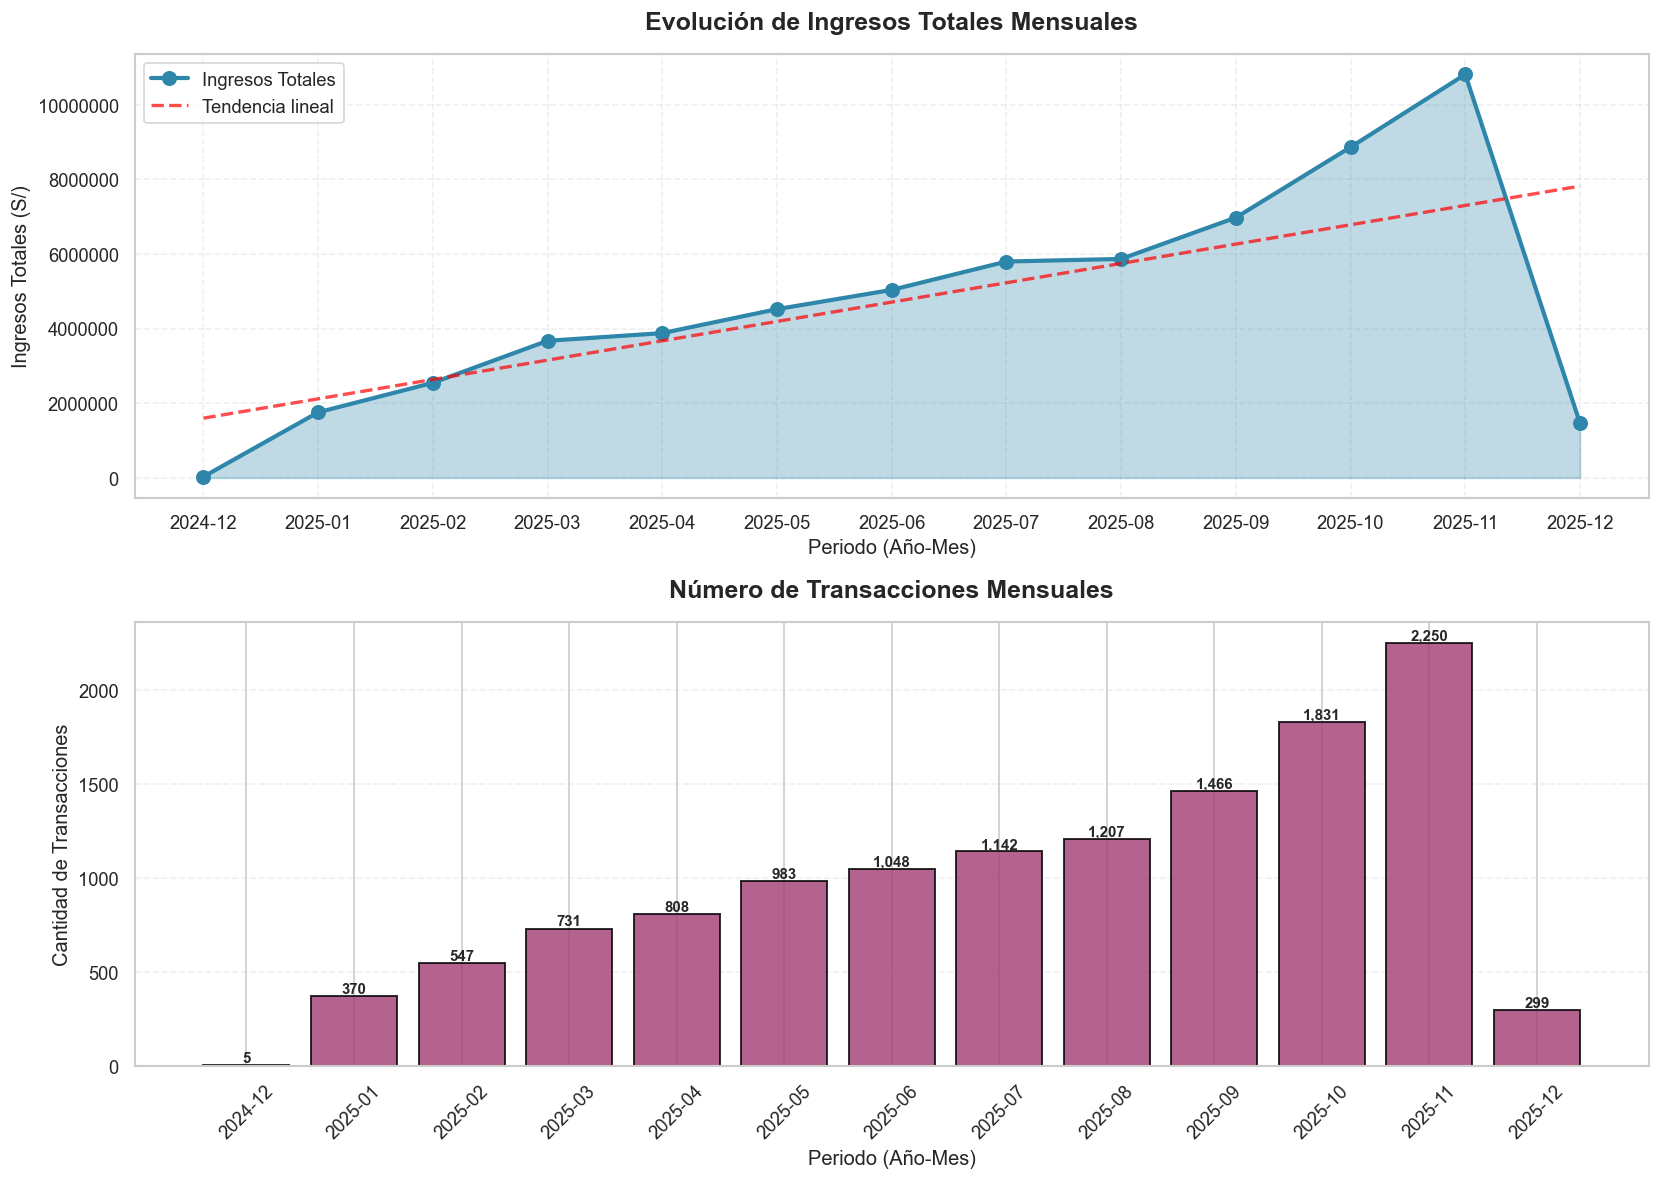

2025-12-11 11:50:45,482 | INFO | Análisis temporal: pico de ventas en 2025-11


In [10]:
# Preparar datos para análisis temporal
ventas_mensuales = ventas.groupby('anio_mes').agg({
    'importe_total': 'sum',
    'id_venta': 'count'
}).rename(columns={'importe_total': 'ingresos_totales', 'id_venta': 'num_transacciones'})

# Crear figura con dos subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Evolución de ingresos totales
axes[0].plot(ventas_mensuales.index, ventas_mensuales['ingresos_totales'], 
             marker='o', linewidth=2.5, markersize=8, color='#2E86AB', label='Ingresos Totales')
axes[0].fill_between(ventas_mensuales.index, ventas_mensuales['ingresos_totales'], 
                      alpha=0.3, color='#2E86AB')
axes[0].set_title('Evolución de Ingresos Totales Mensuales', fontsize=15, fontweight='bold', pad=15)
axes[0].set_xlabel('Periodo (Año-Mes)', fontsize=12)
axes[0].set_ylabel('Ingresos Totales (S/)', fontsize=12)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].legend(loc='upper left', fontsize=11)
axes[0].ticklabel_format(style='plain', axis='y')

# Añadir línea de tendencia
z = np.polyfit(range(len(ventas_mensuales)), ventas_mensuales['ingresos_totales'], 1)
p = np.poly1d(z)
axes[0].plot(ventas_mensuales.index, p(range(len(ventas_mensuales))), 
             linestyle='--', color='red', linewidth=2, alpha=0.7, label='Tendencia lineal')
axes[0].legend(loc='upper left', fontsize=11)

# Gráfico 2: Número de transacciones mensuales
axes[1].bar(ventas_mensuales.index, ventas_mensuales['num_transacciones'], 
            color='#A23B72', alpha=0.8, edgecolor='black', linewidth=1.2)
axes[1].set_title('Número de Transacciones Mensuales', fontsize=15, fontweight='bold', pad=15)
axes[1].set_xlabel('Periodo (Año-Mes)', fontsize=12)
axes[1].set_ylabel('Cantidad de Transacciones', fontsize=12)
axes[1].grid(True, alpha=0.3, linestyle='--', axis='y')

# Añadir valores sobre las barras
for i, (idx, val) in enumerate(ventas_mensuales['num_transacciones'].items()):
    axes[1].text(i, val, f'{int(val):,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
if SAVE_FIGS:
    save_fig('08_evolucion_temporal_ventas')
plt.show()

# Exportar datos temporales
ventas_mensuales.to_csv(EXPORT_DIR / 'ventas_mensuales_detalladas.csv')
EDA_LOGGER.info(f"Análisis temporal: pico de ventas en {ventas_mensuales['ingresos_totales'].idxmax()}")

### 📌 Interpretación: Evolución Temporal de Ventas

**Hallazgos clave:**

1. **Tendencia general:** La línea de tendencia muestra la dirección del crecimiento o decrecimiento en las ventas a lo largo del periodo analizado.

2. **Estacionalidad:** Se observan picos y valles que pueden estar relacionados con:
   - Temporadas festivas (Navidad, Fiestas Patrias, Día de la Madre)
   - Campañas promocionales específicas
   - Factores económicos externos (quincenas, aguinaldos)

3. **Consistencia de transacciones:** El gráfico de barras revela si el volumen de transacciones se mantiene estable o presenta variaciones significativas.

**Recomendaciones de negocio:**
- Planificar inventario y personal para los meses de mayor demanda
- Diseñar campañas promocionales en meses con menor actividad
- Analizar causas de caídas atípicas para prevenir futuras bajas

---
## 🔥 Visualización 2: Heatmap de Correlación entre Variables Numéricas

**Objetivo:** Identificar relaciones lineales entre variables clave del negocio para detectar patrones ocultos.

**Pregunta de negocio:** ¿Qué variables están más relacionadas entre sí? ¿Existe correlación entre cantidad de productos y el importe final de compra?

Preparando datos para análisis de correlación...
Columnas en detalle: ['id_venta', 'id_producto', 'cantidad', 'precio_unitario', 'importe', 'importe_total']
Columnas en ventas: ['id_venta', 'fecha', 'id_cliente', 'medio_pago', 'canal', 'csat_1a5', 'ces_1a5', 'nps_0a10', 'nps_segmento', 'importe_total', 'anio_mes']
Columnas en productos: ['id_producto', 'nombre_producto', 'categoria', 'precio_unitario', 'popularidad']

✓ Dataset enriquecido creado: (12472, 8)
✓ Columnas disponibles: ['id_venta', 'id_producto', 'cantidad', 'precio_unitario', 'importe', 'importe_total', 'fecha', 'importe_total_venta']

⚠️ No se pudo calcular descuento_pct (columnas faltantes)
Variables seleccionadas para correlación: ['cantidad', 'precio_unitario', 'importe', 'descuento_pct']
Filas válidas para análisis: 12,409



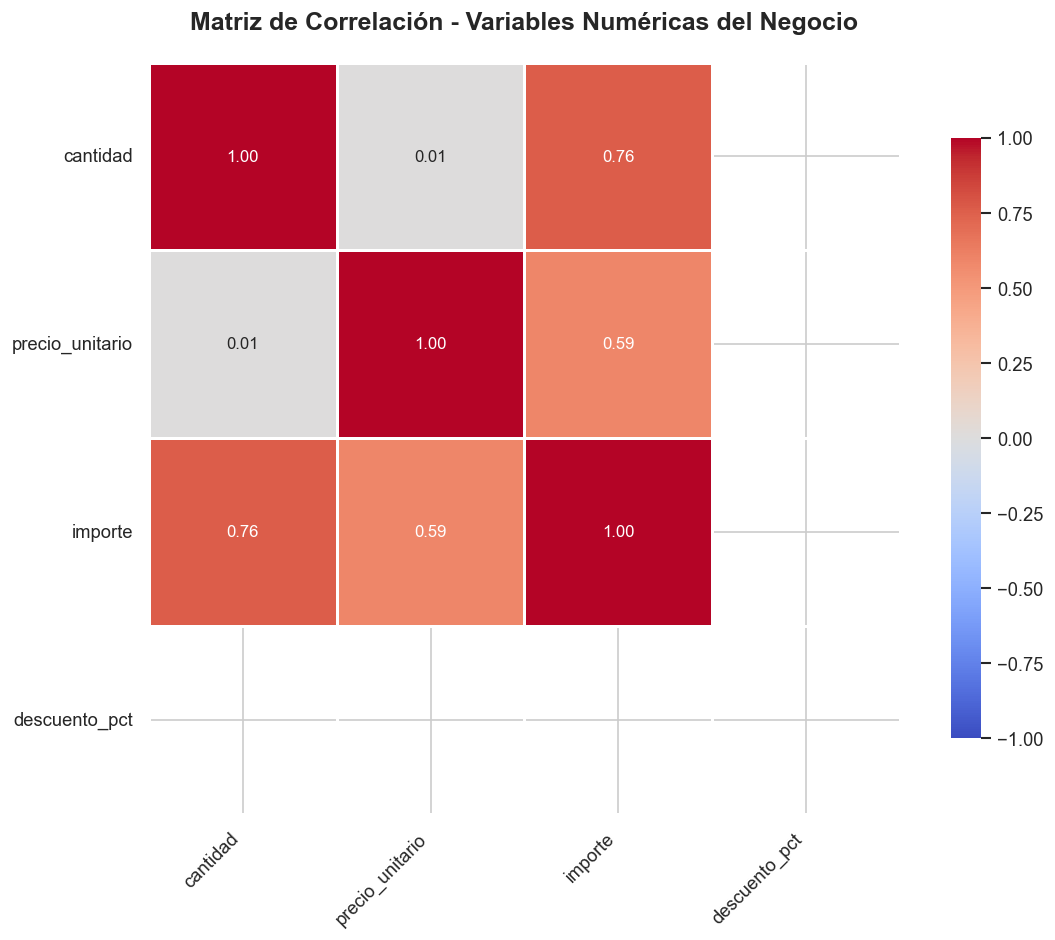

2025-12-11 11:50:46,210 | INFO | Heatmap de correlación generado


CORRELACIONES MÁS RELEVANTES (|r| > 0.5)
cantidad             ↔ importe              =   0.76
precio_unitario      ↔ importe              =   0.59

✅ Heatmap de correlación generado exitosamente


In [11]:
# Preparar dataset para correlación con validaciones
print("Preparando datos para análisis de correlación...")

# Verificar columnas disponibles
print(f"Columnas en detalle: {detalle.columns.tolist()}")
print(f"Columnas en ventas: {ventas.columns.tolist()}")
print(f"Columnas en productos: {productos.columns.tolist()}")

# Merge con ventas (solo columnas necesarias y existentes)
detalle_enriquecido = detalle.copy()
if 'id_venta' in ventas.columns:
    cols_ventas = ['id_venta']
    if 'fecha' in ventas.columns:
        cols_ventas.append('fecha')
    if 'importe_total' in ventas.columns:
        cols_ventas.append('importe_total')
    
    detalle_enriquecido = detalle_enriquecido.merge(
        ventas[cols_ventas], 
        on='id_venta', 
        how='left',
        suffixes=('', '_venta')
    )

# Merge con productos (verificar existencia de columnas)
if 'id_producto' in productos.columns:
    cols_productos = ['id_producto']
    if 'precio_base' in productos.columns:
        cols_productos.append('precio_base')
    elif 'precio' in productos.columns:
        cols_productos.append('precio')
        productos = productos.rename(columns={'precio': 'precio_base'})
    
    detalle_enriquecido = detalle_enriquecido.merge(
        productos[cols_productos], 
        on='id_producto', 
        how='left',
        suffixes=('', '_producto')
    )

print(f"\n✓ Dataset enriquecido creado: {detalle_enriquecido.shape}")
print(f"✓ Columnas disponibles: {detalle_enriquecido.columns.tolist()}\n")

# Calcular descuento porcentual (con validación)
if 'precio_base' in detalle_enriquecido.columns and 'precio_unitario' in detalle_enriquecido.columns:
    detalle_enriquecido['descuento_pct'] = (
        (detalle_enriquecido['precio_base'] - detalle_enriquecido['precio_unitario']) / 
        detalle_enriquecido['precio_base'].replace(0, np.nan) * 100
    ).fillna(0).clip(lower=0, upper=100)
else:
    detalle_enriquecido['descuento_pct'] = 0
    print("⚠️ No se pudo calcular descuento_pct (columnas faltantes)")

# Seleccionar variables numéricas disponibles
columnas_candidatas = ['cantidad', 'precio_unitario', 'importe', 'precio_base', 'descuento_pct']
columnas_disponibles = [col for col in columnas_candidatas if col in detalle_enriquecido.columns]

if len(columnas_disponibles) < 2:
    print("❌ Error: No hay suficientes variables numéricas para correlación")
    print(f"   Columnas disponibles: {detalle_enriquecido.columns.tolist()}")
else:
    # Crear dataset de variables numéricas
    vars_numericas = detalle_enriquecido[columnas_disponibles].copy()
    
    # Eliminar filas con valores nulos o infinitos
    vars_numericas = vars_numericas.replace([np.inf, -np.inf], np.nan).dropna()
    
    print(f"Variables seleccionadas para correlación: {columnas_disponibles}")
    print(f"Filas válidas para análisis: {len(vars_numericas):,}\n")
    
    # Calcular matriz de correlación
    matriz_corr = vars_numericas.corr()
    
    # Crear heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Usar try-except para manejar posibles errores de visualización
    try:
        sns.heatmap(matriz_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                    square=True, linewidths=1.5, cbar_kws={"shrink": 0.8}, 
                    vmin=-1, vmax=1, ax=ax, annot_kws={'size': 10})
        
        ax.set_title('Matriz de Correlación - Variables Numéricas del Negocio', 
                     fontsize=15, fontweight='bold', pad=20)
        plt.yticks(rotation=0)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        if SAVE_FIGS:
            save_fig('09_heatmap_correlacion')
        plt.show()
        
        # Exportar matriz de correlación
        matriz_corr.to_csv(EXPORT_DIR / 'matriz_correlacion.csv')
        
        # Mostrar correlaciones más fuertes
        print("="*80)
        print("CORRELACIONES MÁS RELEVANTES (|r| > 0.5)")
        print("="*80)
        
        # Extraer correlaciones significativas
        for i in range(len(matriz_corr.columns)):
            for j in range(i+1, len(matriz_corr.columns)):
                corr_val = matriz_corr.iloc[i, j]
                if abs(corr_val) > 0.5:
                    var1 = matriz_corr.columns[i]
                    var2 = matriz_corr.columns[j]
                    print(f"{var1:20} ↔ {var2:20} = {corr_val:>6.2f}")
        
        print("="*80)
        print("\n✅ Heatmap de correlación generado exitosamente")
        EDA_LOGGER.info("Heatmap de correlación generado")
        
    except Exception as e:
        print(f"❌ Error al generar heatmap: {str(e)}")
        print("Mostrando matriz de correlación en formato texto:")
        print(matriz_corr)
        EDA_LOGGER.error(f"Error en heatmap: {str(e)}")

### 📌 Interpretación: Correlación entre Variables

**Cómo leer el heatmap:**
- Valores cercanos a **+1** (rojo intenso): correlación positiva fuerte
- Valores cercanos a **-1** (azul intenso): correlación negativa fuerte
- Valores cercanos a **0** (blanco): sin correlación lineal

**Hallazgos esperados:**

1. **cantidad vs importe:** Correlación positiva esperada (más productos = mayor importe)
2. **precio_unitario vs importe:** Relación directa entre precio y venta total
3. **descuento_pct vs cantidad:** Investigar si los descuentos impulsan compras mayores

**Aplicación estratégica:**
- Si `descuento_pct` correlaciona positivamente con `cantidad`, validamos la efectividad de promociones
- Correlaciones débiles sugieren variables independientes que requieren estrategias diferenciadas
- Identificar productos con alta correlación precio-volumen para optimizar márgenes

---
## 🎯 Visualización 3: Scatter Plot - Relación Precio vs Cantidad Vendida

**Objetivo:** Analizar la elasticidad precio-demanda y detectar segmentos de productos según su comportamiento de venta.

**Pregunta de negocio:** ¿Los productos más caros se venden en menor cantidad? ¿Existen productos premium que desafían esta lógica?

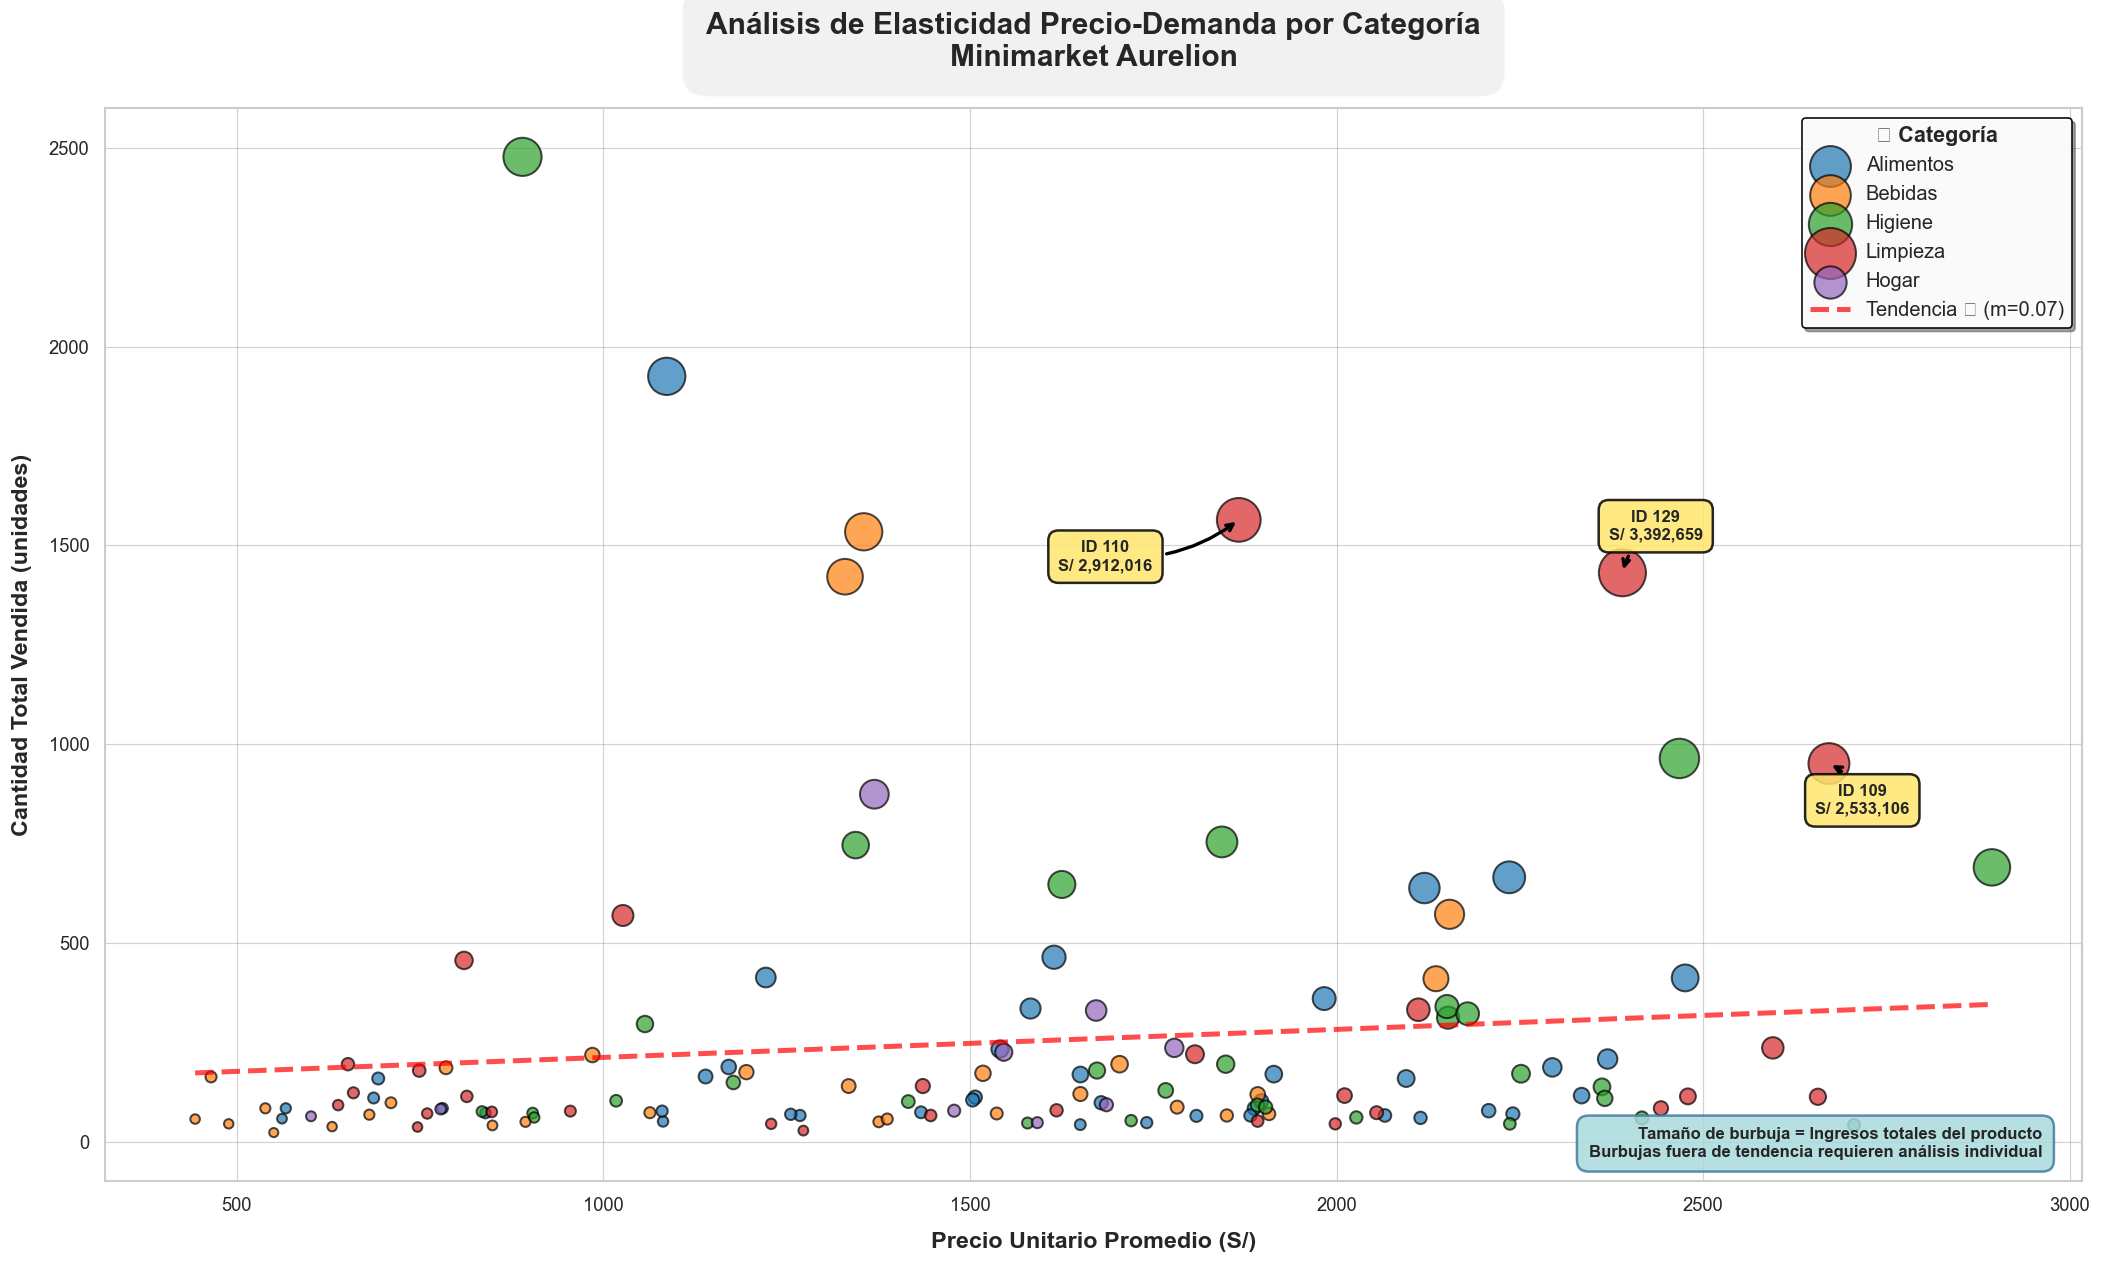

2025-12-11 11:50:47,908 | INFO | Scatter plot generado: 139 productos, correlación=0.11418394712747745


RESUMEN: ANÁLISIS PRECIO VS CANTIDAD
📊 Total productos analizados:     139
💰 Precio unitario promedio:       S/ 1539.09
📦 Cantidad promedio vendida:      250 unidades
💵 Ingreso promedio por producto:  S/ 409,036.89
📈 Correlación precio-cantidad:    0.114 (débil)


In [12]:
# Scatter plot precio vs cantidad
producto_stats = detalle.groupby('id_producto').agg({
    'precio_unitario': 'mean',
    'cantidad': 'sum',
    'importe': 'sum'
}).reset_index()
producto_stats = producto_stats.merge(productos[['id_producto', 'categoria']], on='id_producto', how='left')

fig, ax = plt.subplots(figsize=(18, 11))
categorias_unicas = producto_stats['categoria'].dropna().unique()
paleta = sns.color_palette('tab10', n_colors=len(categorias_unicas))
color_map = dict(zip(categorias_unicas, paleta))

size_min, size_max = 30, 800
importe_min = producto_stats['importe'].min() if not producto_stats.empty else 0.0
importe_max = producto_stats['importe'].max() if not producto_stats.empty else 0.0
rango_importe = float(importe_max - importe_min)
if producto_stats.empty or np.isclose(rango_importe, 0.0):
    size_scaled = pd.Series((size_min + size_max) / 2.0, index=producto_stats.index, dtype=float)
else:
    size_scaled = (
        size_min + (size_max - size_min) *
        (producto_stats['importe'] - importe_min) /
        rango_importe
    )

for categoria in categorias_unicas:
    mask = producto_stats['categoria'] == categoria
    subset = producto_stats[mask]
    subset_sizes = size_scaled[mask]
    ax.scatter(
        subset['precio_unitario'],
        subset['cantidad'],
        s=subset_sizes,
        alpha=0.7,
        c=[color_map[categoria]],
        label=categoria,
        edgecolors='black',
        linewidth=1.2
    )

ax.set_title('Análisis de Elasticidad Precio-Demanda por Categoría\nMinimarket Aurelion', fontsize=18, fontweight='bold', pad=25,
             bbox=dict(boxstyle='round,pad=0.8', facecolor='lightgray', alpha=0.3))
ax.set_xlabel('Precio Unitario Promedio (S/)', fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Cantidad Total Vendida (unidades)', fontsize=14, fontweight='bold', labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.grid(True, alpha=0.35, linestyle='-', linewidth=0.7, color='gray')
ax.set_axisbelow(True)

datos_validos = producto_stats[['precio_unitario', 'cantidad']].dropna()
corr_val = np.nan
if len(datos_validos) > 1:
    z = np.polyfit(datos_validos['precio_unitario'], datos_validos['cantidad'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(datos_validos['precio_unitario'].min(), datos_validos['precio_unitario'].max(), 100)
    pendiente = z[0]
    signo = '↘' if pendiente < 0 else '↗'
    ax.plot(x_trend, p(x_trend), linestyle='--', color='red', linewidth=3, alpha=0.7,
            label=f'Tendencia {signo} (m={pendiente:.2f})', zorder=5)
    corr_val = float(datos_validos['precio_unitario'].corr(datos_validos['cantidad']))

legend = ax.legend(title='📊 Categoría', loc='best', fontsize=12, framealpha=0.95,
                   edgecolor='black', fancybox=True, shadow=True, title_fontsize=13, markerscale=1.5)
legend.get_title().set_fontweight('bold')

top_productos = producto_stats.nlargest(3, 'importe')
offset_positions = [(20, 20), (-80, -30), (20, -30)]
for idx, (_, row) in enumerate(top_productos.iterrows()):
    offset_x, offset_y = offset_positions[idx % 3]
    ax.annotate(
        f"ID {row['id_producto']}\nS/ {row['importe']:,.0f}",
        xy=(row['precio_unitario'], row['cantidad']),
        xytext=(offset_x, offset_y),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.6', fc='#FFE66D', alpha=0.85, edgecolor='black', linewidth=1.5),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', color='black', lw=2),
        fontsize=10,
        fontweight='bold',
        ha='center'
    )

nota_texto = ('Tamaño de burbuja = Ingresos totales del producto\n'
              'Burbujas fuera de tendencia requieren análisis individual')
ax.text(0.98, 0.02, nota_texto, transform=ax.transAxes,
        fontsize=10, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.7', facecolor='#A8DADC', alpha=0.85, edgecolor='#457B9D', linewidth=1.5),
        fontweight='bold')

plt.tight_layout(pad=2.0)
if SAVE_FIGS:
    save_fig('10_scatter_precio_cantidad', dpi=200)
plt.show()

producto_stats_export = producto_stats.copy()
producto_stats_export['ingreso_promedio_por_unidad'] = (
    producto_stats_export['importe'] /
    producto_stats_export['cantidad'].replace({0: np.nan})
).round(2)
producto_stats_export['tamaño_burbuja'] = size_scaled
producto_stats_export = producto_stats_export.sort_values('importe', ascending=False)
producto_stats_export.to_csv(EXPORT_DIR / 'estadisticas_por_producto.csv', index=False)

print('=' * 80)
print('RESUMEN: ANÁLISIS PRECIO VS CANTIDAD')
print('=' * 80)
print(f"📊 Total productos analizados:     {len(producto_stats):,}")
print(f"💰 Precio unitario promedio:       S/ {producto_stats['precio_unitario'].mean():.2f}")
print(f"📦 Cantidad promedio vendida:      {producto_stats['cantidad'].mean():.0f} unidades")
print(f"💵 Ingreso promedio por producto:  S/ {producto_stats['importe'].mean():,.2f}")
if not np.isnan(corr_val):
    intensidad = 'débil' if abs(corr_val) < 0.3 else 'moderada' if abs(corr_val) < 0.7 else 'fuerte'
    print(f"📈 Correlación precio-cantidad:    {corr_val:.3f} ({intensidad})")
print('=' * 80)
EDA_LOGGER.info(f"Scatter plot generado: {len(producto_stats)} productos, correlación={corr_val if not np.isnan(corr_val) else 'NA'}")

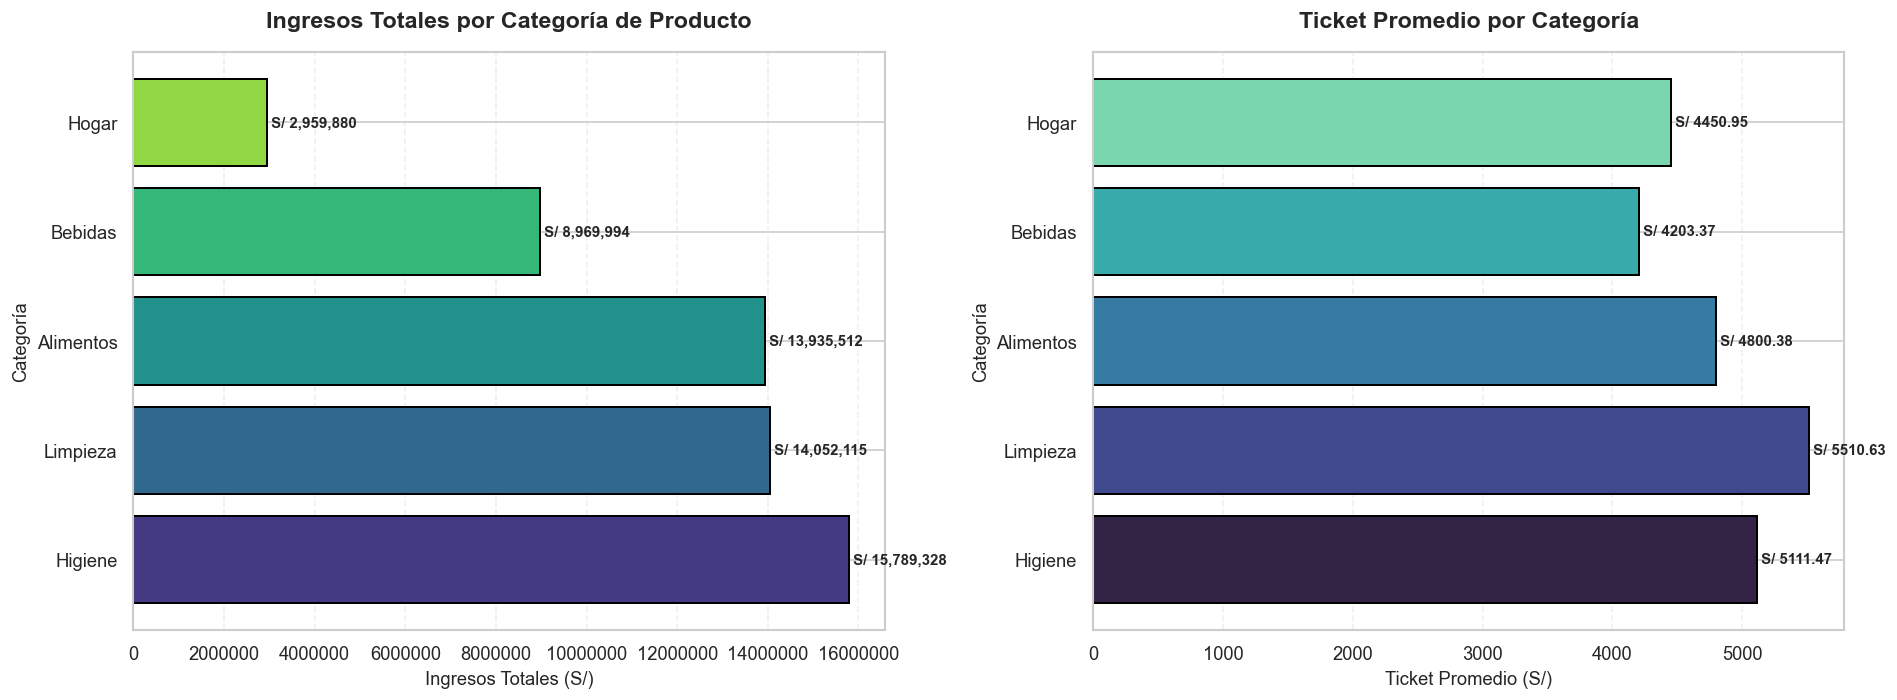

2025-12-11 11:50:48,819 | INFO | Categoría top: Higiene con S/ 15,789,328.00



✅ Análisis de categorías completado y exportado


In [13]:
# Análisis por categoría
detalle_con_categoria = detalle.merge(productos[['id_producto', 'categoria']], on='id_producto', how='left')
categoria_stats = detalle_con_categoria.groupby('categoria').agg({
    'importe': ['sum', 'mean', 'count']
}).round(2)
categoria_stats.columns = ['Ingresos_Totales', 'Ticket_Promedio', 'Num_Transacciones']
categoria_stats = categoria_stats.sort_values('Ingresos_Totales', ascending=False).reset_index()

# Crear gráfico de barras comparativo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Ingresos totales por categoría
colors_ingresos = sns.color_palette('viridis', n_colors=len(categoria_stats))
axes[0].barh(categoria_stats['categoria'], categoria_stats['Ingresos_Totales'], 
             color=colors_ingresos, edgecolor='black', linewidth=1.2)
axes[0].set_title('Ingresos Totales por Categoría de Producto', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Ingresos Totales (S/)', fontsize=11)
axes[0].set_ylabel('Categoría', fontsize=11)
axes[0].grid(axis='x', alpha=0.3, linestyle='--')
axes[0].ticklabel_format(style='plain', axis='x')

# Añadir valores en las barras
for i, v in enumerate(categoria_stats['Ingresos_Totales']):
    axes[0].text(v, i, f' S/ {v:,.0f}', va='center', fontsize=9, fontweight='bold')

# Gráfico 2: Ticket promedio por categoría
colors_ticket = sns.color_palette('mako', n_colors=len(categoria_stats))
axes[1].barh(categoria_stats['categoria'], categoria_stats['Ticket_Promedio'], 
             color=colors_ticket, edgecolor='black', linewidth=1.2)
axes[1].set_title('Ticket Promedio por Categoría', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Ticket Promedio (S/)', fontsize=11)
axes[1].set_ylabel('Categoría', fontsize=11)
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

# Añadir valores en las barras
for i, v in enumerate(categoria_stats['Ticket_Promedio']):
    axes[1].text(v, i, f' S/ {v:.2f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
if SAVE_FIGS:
    save_fig('11_comparativa_categorias')
plt.show()

# Exportar estadísticas por categoría
categoria_stats.to_csv(EXPORT_DIR / 'estadisticas_por_categoria.csv', index=False)
print("\n✅ Análisis de categorías completado y exportado")
EDA_LOGGER.info(f"Categoría top: {categoria_stats.iloc[0]['categoria']} con S/ {categoria_stats.iloc[0]['Ingresos_Totales']:,.2f}")

### 📌 Interpretación: Desempeño por Categoría

**Análisis dual de categorías:**

**Panel izquierdo (Ingresos Totales):**
- Identifica las categorías que más contribuyen a la facturación
- Categorías en la parte superior son prioritarias para gestión de inventario
- Útil para asignación de espacio en góndolas y negociaciones con proveedores

**Panel derecho (Ticket Promedio):**
- Muestra el valor promedio de compra por transacción en cada categoría
- Ticket alto + volumen bajo = productos especializados o premium
- Ticket bajo + volumen alto = productos de consumo masivo

**Estrategias recomendadas:**
1. **Categorías con alto ingreso total:** Asegurar disponibilidad constante, evitar quiebres de stock
2. **Categorías con ticket alto:** Considerar estrategias de venta cruzada y bundling
3. **Categorías con bajo desempeño:** Evaluar si mantenerlas, renegociar con proveedores o descontinuar
4. **Oportunidad de crecimiento:** Categorías con ticket promedio alto pero bajo volumen pueden beneficiarse de marketing dirigido

---
## 🔍 Resumen de Insights de Visualizaciones

**Conexión entre gráficos:**

1. **Temporal + Correlación:** Las tendencias mensuales se explican parcialmente por correlaciones entre variables (ej. descuentos en meses de baja)

2. **Scatter + Categorías:** Los segmentos identificados en el scatter plot se agrupan por categoría en el análisis comparativo

3. **Todos los gráficos:** Permiten construir una narrativa completa del comportamiento del negocio

**Próximos pasos sugeridos:**
- Validar hipótesis de estacionalidad con tests estadísticos
- Segmentar clientes según patrones de compra observados
- Implementar modelos predictivos para forecasting de ventas
- Diseñar experimentos A/B para validar estrategias de pricing

---
# 9️⃣ HALLAZGOS EJECUTIVOS <a id="hallazgos"></a>

Resume hallazgos clave del análisis exploratorio y sugiere acciones o hipótesis para negocio o ML.

In [14]:
# Resumen de hallazgos ejecutivos
# Cálculo robusto de outliers (IQR) si no se ha realizado antes
serie_importes = ventas['importe_total'].dropna() if 'importe_total' in ventas.columns else importe_total.dropna()
if len(serie_importes) > 0:
    Q1 = float(serie_importes.quantile(0.25))
    Q3 = float(serie_importes.quantile(0.75))
    IQR = Q3 - Q1
    li = Q1 - 1.5 * IQR
    ls = Q3 + 1.5 * IQR
    mask_outliers_h = (serie_importes < li) | (serie_importes > ls)
    n_outliers = int(mask_outliers_h.sum())
    pct_outliers = (n_outliers / len(serie_importes)) * 100
else:
    n_outliers = 0
    pct_outliers = 0.0

hallazgos = {
    'Total ventas analizadas': ventas.shape[0],
    'Periodo analizado': f"{ventas['fecha'].min().date()} a {ventas['fecha'].max().date()}",
    'Ticket promedio general': f"S/ {importe_total.mean():.2f}",
    'Productos clase A': f"{df_abc_productos[df_abc_productos['Clasificacion']=='A'].shape[0]} ({df_abc_productos[df_abc_productos['Clasificacion']=='A']['% Individual'].sum():.1f}% ingresos)",
    'Outliers detectados': f"{n_outliers} ({pct_outliers:.2f}%)",
}
print("="*80)
print("RESUMEN EJECUTIVO DE HALLAZGOS")
print("="*80)
for k, v in hallazgos.items():
    print(f"• {k}: {v}")
print("="*80)
pd.DataFrame(list(hallazgos.items()), columns=['Métrica', 'Valor']).to_csv(EXPORT_DIR / 'resumen_hallazgos.csv', index=False)
print("\n✅ Hallazgos exportados a: export/resumen_hallazgos.csv")
EDA_LOGGER.info("Resumen ejecutivo generado y exportado")

2025-12-11 11:50:48,892 | INFO | Resumen ejecutivo generado y exportado


RESUMEN EJECUTIVO DE HALLAZGOS
• Total ventas analizadas: 12687
• Periodo analizado: 2024-12-27 a 2025-12-03
• Ticket promedio general: S/ 4827.56
• Productos clase A: 44 (79.7% ingresos)
• Outliers detectados: 112 (0.88%)

✅ Hallazgos exportados a: export/resumen_hallazgos.csv


---

<a id='exportaciones'></a>
## 🔟 EXPORTACIONES Y LOGGING

Consolidación de todas las exportaciones realizadas y cierre del análisis exploratorio.

In [15]:
# Verificar archivos exportados
export_files = sorted(EXPORT_DIR.glob('*.csv'))
print("="*80)
print("ARCHIVOS EXPORTADOS DURANTE EL EDA")
print("="*80)
for i, f in enumerate(export_files, 1):
    size_kb = f.stat().st_size / 1024
    print(f"{i:2}. {f.name:<45} ({size_kb:>8.2f} KB)")
print("="*80)
print(f"Total: {len(export_files)} archivos CSV generados\n")

# Guardar lista de exportaciones
df_exports = pd.DataFrame({
    'Archivo': [f.name for f in export_files],
    'Tamaño_KB': [f.stat().st_size / 1024 for f in export_files]
})
df_exports.to_csv(EXPORT_DIR / 'resumen_exportaciones_eda.csv', index=False)

# Verificar visualizaciones guardadas
viz_files = sorted(FIG_DIR.glob('*.png'))
print("VISUALIZACIONES GUARDADAS")
print("="*80)
for i, f in enumerate(viz_files, 1):
    print(f"{i:2}. {f.name}")
print("="*80)
print(f"Total: {len(viz_files)} gráficos guardados\n")

# Cierre de logging
EDA_LOGGER.info("="*80)
EDA_LOGGER.info("EDA COMPLETADO EXITOSAMENTE")
EDA_LOGGER.info(f"Archivos exportados: {len(export_files)}")
EDA_LOGGER.info(f"Visualizaciones generadas: {len(viz_files)}")
EDA_LOGGER.info("="*80)

print("✅ EDA FINALIZADO - Todos los resultados han sido exportados")
print(f"📂 Exportaciones CSV: {EXPORT_DIR}")
print(f"📊 Visualizaciones PNG: {FIG_DIR}")
print(f"📋 Logs: {EXPORT_DIR / 'eda_log.log'}")

2025-12-11 11:50:48,972 | INFO | ================================================================================
2025-12-11 11:50:48,973 | INFO | EDA COMPLETADO EXITOSAMENTE
2025-12-11 11:50:48,974 | INFO | Archivos exportados: 31
2025-12-11 11:50:48,975 | INFO | Visualizaciones generadas: 20
2025-12-11 11:50:48,976 | INFO | ================================================================================


ARCHIVOS EXPORTADOS DURANTE EL EDA
 1. abc_clientes_validacion.csv                   (    0.16 KB)
 2. ciudad_provincia_argentina.csv                (    0.86 KB)
 3. clasificacion_abc_clientes.csv                (   13.34 KB)
 4. clasificacion_abc_productos.csv               (    3.57 KB)
 5. clientes_ciudad_imputada_bsas.csv             (    0.50 KB)
 6. correlaciones_cx_cliente.csv                  (    0.57 KB)
 7. distribucion_canales_venta.csv                (    0.15 KB)
 8. distribucion_medio_pago.csv                   (    0.11 KB)
 9. estadisticas_por_categoria.csv                (    0.22 KB)
10. estadisticas_por_producto.csv                 (    9.44 KB)
11. matriz_correlacion.csv                        (    0.23 KB)
12. metricas_retencion_2025.csv                   (    0.27 KB)
13. nps_mensual.csv                               (    0.14 KB)
14. out_abc_clientes.csv                          (   21.92 KB)
15. out_abc_productos.csv                         (    6.50 KB)
16. o

## 🔧 Corrección de exportación: incluir id_cliente en clasificacion_abc_clientes.csv
Aseguramos que el archivo de salida contenga la columna `id_cliente` (si la clasificación quedó con el id como índice).

In [16]:
# Reconstruye/exporta clasificacion_abc_clientes con id_cliente explícito
from pathlib import Path
import pandas as pd
EXPORT_DIR = Path.cwd() / 'export'
EXPORT_DIR.mkdir(exist_ok=True)
out_path = EXPORT_DIR / 'clasificacion_abc_clientes.csv'
try:
    df_export = df_abc_clientes.copy()
except NameError:
    raise RuntimeError('df_abc_clientes no está disponible en el kernel. Ejecuta las celdas de ABC previamente.')
if 'id_cliente' not in df_export.columns:
    # Si el índice representa id_cliente, restáuralo a columna
    if getattr(df_export.index, 'name', None) in (None, 'id_cliente') or df_export.index.nlevels == 1:
        df_export = df_export.reset_index()
        if 'index' in df_export.columns and 'id_cliente' not in df_export.columns:
            df_export = df_export.rename(columns={'index': 'id_cliente'})
    # Si aún no existe, intentar mapear desde clientes si hay email o nombre
    if 'id_cliente' not in df_export.columns:
        posibles_keys = [c for c in ['email','nombre_cliente'] if c in df_export.columns and c in clientes.columns]
        if posibles_keys:
            key = posibles_keys[0]
            df_export = df_export.merge(clientes[['id_cliente', key]], on=key, how='left')
# Ordenar columnas con id_cliente primero si existe
cols = list(df_export.columns)
if 'id_cliente' in cols:
    cols = ['id_cliente'] + [c for c in cols if c != 'id_cliente']
    df_export = df_export[cols]
else:
    print('⚠️ No fue posible recuperar id_cliente; se exportará sin esa columna.')
df_export.to_csv(out_path, index=False, encoding='utf-8')
print(f'✅ Export actualizado con id_cliente (si disponible): {out_path}')

✅ Export actualizado con id_cliente (si disponible): c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\export\clasificacion_abc_clientes.csv


## Experiencia de Cliente (CSAT, CES, NPS)

En esta sección exploramos las métricas de experiencia del cliente recientemente incorporadas al pipeline: `csat_1a5`, `ces_1a5`, `nps_0a10` y `nps_segmento`. Se reportan distribuciones, NPS global y mensual, y correlaciones simples con recurrencia/ticket.


In [17]:
# Carga/valida columnas de CX solamente desde datasets_limpios/ventas_clean.csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

cols_cx = ["csat_1a5", "ces_1a5", "nps_0a10", "nps_segmento"]

ventas_path = DATASETS_LIMPIOS / "ventas_clean.csv"
ventas = pd.read_csv(ventas_path)
if "fecha" in ventas.columns:
    ventas["fecha"] = pd.to_datetime(ventas["fecha"], errors="coerce")

# Tipos y normalización
for c in ["csat_1a5", "ces_1a5"]:
    if c in ventas.columns:
        ventas[c] = pd.to_numeric(ventas[c], errors="coerce")
        ventas.loc[~ventas[c].between(1,5), c] = np.nan
if "nps_0a10" in ventas.columns:
    ventas["nps_0a10"] = pd.to_numeric(ventas["nps_0a10"], errors="coerce")
    ventas.loc[~ventas["nps_0a10"].between(0,10), "nps_0a10"] = np.nan

# Función NPS
def nps_score(series: pd.Series) -> float:
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty:
        return np.nan
    prom = (s >= 9).mean()
    detr = (s <= 6).mean()
    return (prom - detr) * 100

DOCS_DIR = BASE_DIR / "docs"
DOCS_DIR.mkdir(parents=True, exist_ok=True)
EXPORT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("Fuente única de CX:", ventas_path)
print("Registros con algún CX:", ventas[[c for c in cols_cx if c in ventas.columns]].dropna(how="all").shape[0])

Fuente única de CX: c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\datasets_limpios\ventas_clean.csv
Registros con algún CX: 12204


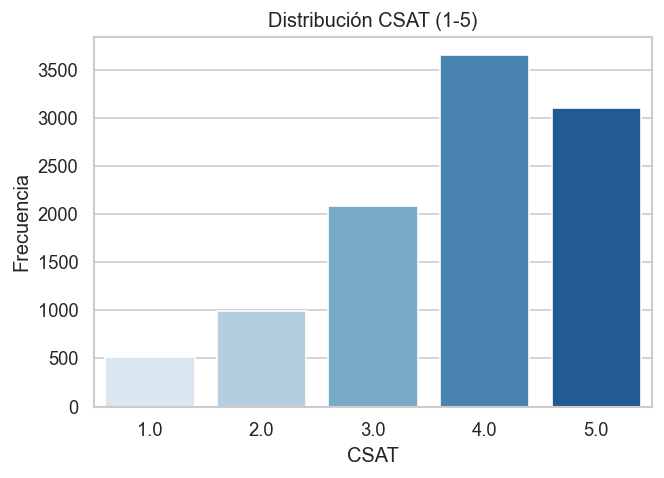

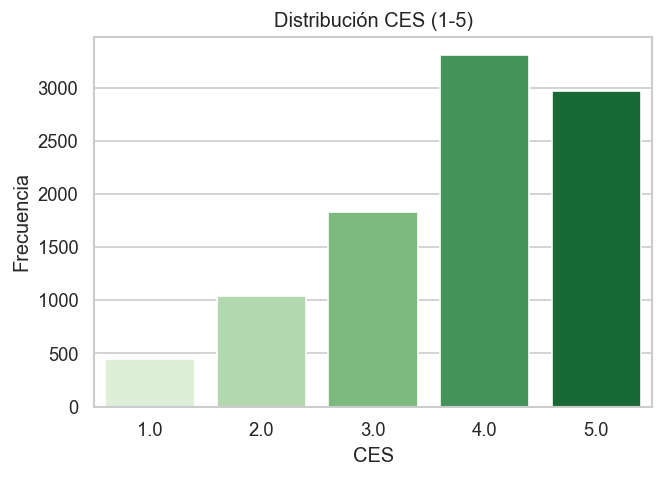

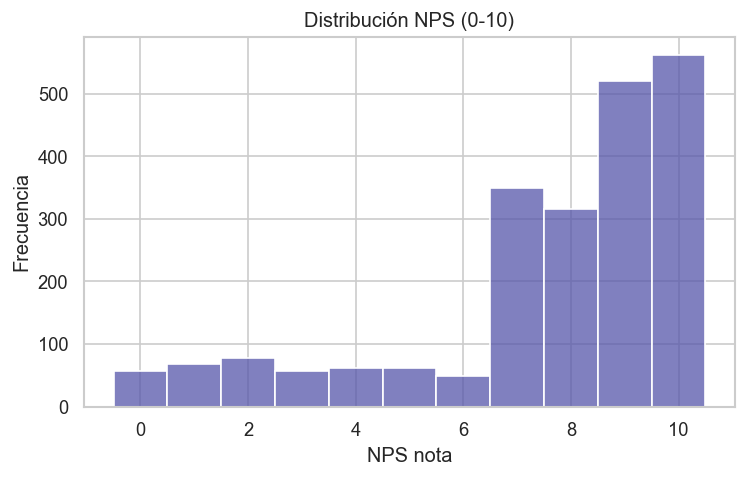

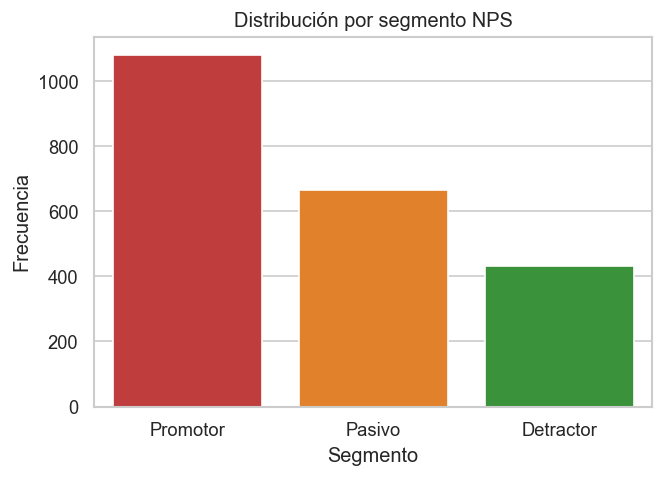

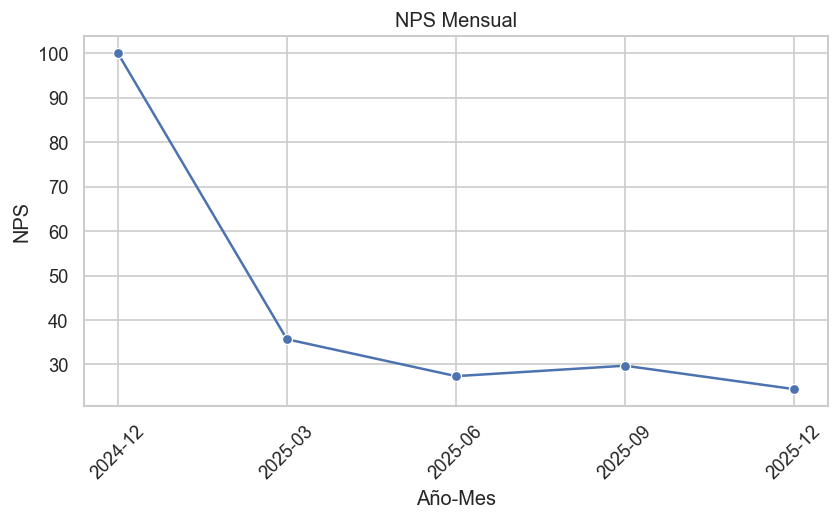

NPS Global: 29.9
Exportado: c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\export\resumen_cx.csv
Exportado: c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\export\nps_mensual.csv
Documento: c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\docs\resumen_cx.md


In [18]:
# Distribuciones CSAT/CES y NPS + NPS global y mensual
sns.set(style="whitegrid")

# CSAT
if "csat_1a5" in ventas.columns:
    plt.figure(figsize=(6,4))
    ax = sns.countplot(x="csat_1a5", data=ventas, palette="Blues", order=sorted(ventas["csat_1a5"].dropna().unique()))
    plt.title("Distribución CSAT (1-5)")
    plt.xlabel("CSAT")
    plt.ylabel("Frecuencia")
    if 'SAVE_FIGS' in globals() and SAVE_FIGS:
        out_path = FIG_DIR / "eda_csat_distribucion.png"
        plt.savefig(out_path, bbox_inches="tight")
    plt.show()

# CES
if "ces_1a5" in ventas.columns:
    plt.figure(figsize=(6,4))
    ax = sns.countplot(x="ces_1a5", data=ventas, palette="Greens", order=sorted(ventas["ces_1a5"].dropna().unique()))
    plt.title("Distribución CES (1-5)")
    plt.xlabel("CES")
    plt.ylabel("Frecuencia")
    if 'SAVE_FIGS' in globals() and SAVE_FIGS:
        out_path = FIG_DIR / "eda_ces_distribucion.png"
        plt.savefig(out_path, bbox_inches="tight")
    plt.show()

# NPS: distribución de notas y segmentos si existe
if "nps_0a10" in ventas.columns:
    plt.figure(figsize=(7,4))
    ax = sns.histplot(ventas["nps_0a10"], bins=np.arange(-0.5, 10.6, 1), color="#5555aa")
    plt.title("Distribución NPS (0-10)")
    plt.xlabel("NPS nota")
    plt.ylabel("Frecuencia")
    if 'SAVE_FIGS' in globals() and SAVE_FIGS:
        out_path = FIG_DIR / "eda_nps_distribucion.png"
        plt.savefig(out_path, bbox_inches="tight")
    plt.show()

if "nps_segmento" in ventas.columns:
    plt.figure(figsize=(6,4))
    ax = sns.countplot(x="nps_segmento", data=ventas, palette=["#d62728", "#ff7f0e", "#2ca02c"])
    plt.title("Distribución por segmento NPS")
    plt.xlabel("Segmento")
    plt.ylabel("Frecuencia")
    if 'SAVE_FIGS' in globals() and SAVE_FIGS:
        out_path = FIG_DIR / "eda_nps_segmento.png"
        plt.savefig(out_path, bbox_inches="tight")
    plt.show()

# NPS Global y mensual
nps_global = np.nan
nps_mensual = pd.DataFrame()
if "nps_0a10" in ventas.columns:
    nps_global = nps_score(ventas["nps_0a10"])
    if "fecha" in ventas.columns:
        tmp = ventas.dropna(subset=["nps_0a10"]).copy()
        tmp["anio_mes"] = tmp["fecha"].dt.to_period("M").astype(str)
        nps_mensual = (
            tmp.groupby("anio_mes")["nps_0a10"].apply(nps_score).reset_index(name="nps_score")
        )
        plt.figure(figsize=(8,4))
        sns.lineplot(data=nps_mensual, x="anio_mes", y="nps_score", marker="o")
        plt.title("NPS Mensual")
        plt.xlabel("Año-Mes")
        plt.ylabel("NPS")
        plt.xticks(rotation=45)
        if 'SAVE_FIGS' in globals() and SAVE_FIGS:
            out_path = FIG_DIR / "eda_nps_mensual.png"
            plt.savefig(out_path, bbox_inches="tight")
        plt.show()

print(f"NPS Global: {nps_global:.1f}" if pd.notna(nps_global) else "NPS Global: NA")

# Exportar resúmenes a CSV/MD
resumen_cx = {
    "csat_medio": [ventas["csat_1a5"].mean() if "csat_1a5" in ventas.columns else np.nan],
    "ces_medio": [ventas["ces_1a5"].mean() if "ces_1a5" in ventas.columns else np.nan],
    "nps_global": [nps_global],
    "registros_con_cx": [int(ventas[[c for c in cols_cx if c in ventas.columns]].dropna(how="all").shape[0])],
}
resumen_cx_df = pd.DataFrame(resumen_cx)
resumen_cx_df.to_csv(EXPORT_DIR / "resumen_cx.csv", index=False)

if not nps_mensual.empty:
    nps_mensual.to_csv(EXPORT_DIR / "nps_mensual.csv", index=False)

md_lines = [
    "# Resumen CX (EDA)",
    f"- CSAT medio: {resumen_cx['csat_medio'][0]:.2f}" if pd.notna(resumen_cx['csat_medio'][0]) else "- CSAT medio: NA",
    f"- CES medio: {resumen_cx['ces_medio'][0]:.2f}" if pd.notna(resumen_cx['ces_medio'][0]) else "- CES medio: NA",
    f"- NPS global: {nps_global:.1f}" if pd.notna(nps_global) else "- NPS global: NA",
    f"- Registros con al menos una métrica CX: {resumen_cx['registros_con_cx'][0]}",
]
(DOCS_DIR / "resumen_cx.md").write_text("\n".join(md_lines), encoding="utf-8")

print("Exportado:", EXPORT_DIR / "resumen_cx.csv")
if not nps_mensual.empty:
    print("Exportado:", EXPORT_DIR / "nps_mensual.csv")
print("Documento:", DOCS_DIR / "resumen_cx.md")

In [19]:
# Correlaciones simples: recurrencia y ticket vs CX
# Recurrencia por cliente y ticket promedio, luego correlación con CSAT/CES/NPS promediados por cliente
cols_exist = [c for c in ["id_cliente", "importe", "csat_1a5", "ces_1a5", "nps_0a10"] if c in ventas.columns]
if all(c in cols_exist for c in ["id_cliente"]):
    agg_cli = ventas.groupby("id_cliente").agg(
        compras=("id_venta", "nunique") if "id_venta" in ventas.columns else ("fecha", "count"),
        ticket_promedio=("importe", "mean") if "importe" in ventas.columns else ("id_cliente", "count")
    )
    for c in ["csat_1a5", "ces_1a5", "nps_0a10"]:
        if c in ventas.columns:
            agg_cli[c + "_mean"] = ventas.groupby("id_cliente")[c].mean()
    # Correlaciones (solo columnas numéricas)
    corr_cols = [c for c in agg_cli.columns if agg_cli[c].dtype != 'O']
    corr_mat = agg_cli[corr_cols].corr()
    print("Correlaciones (compras/ticket vs CX promedios):")
    cols_to_show = [c for c in corr_cols if any(k in c for k in ["compras", "ticket_promedio", "csat", "ces", "nps"]) ]
    display(corr_mat.loc[cols_to_show, cols_to_show])

    # Exportar a CSV
    corr_mat.to_csv(EXPORT_DIR / "correlaciones_cx_cliente.csv")
else:
    print("No se puede calcular correlaciones por cliente: falta 'id_cliente'.")

Correlaciones (compras/ticket vs CX promedios):


,compras,ticket_promedio,csat_1a5_mean,ces_1a5_mean,nps_0a10_mean
compras,1.00,1.00,0.01,-0.00,-0.01
ticket_promedio,1.00,1.00,0.01,-0.00,-0.01
csat_1a5_mean,0.01,0.01,1.00,0.09,-0.08
ces_1a5_mean,-0.00,-0.00,0.09,1.00,0.08
nps_0a10_mean,-0.01,-0.01,-0.08,0.08,1.00
